## チュートリアルをKFOLDで実施する

### 目的

1. 最適なepoch数を知る

2. データ拡張を増やす(albumentationを使用するように修正する)

In [1]:
import copy

import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
from multiprocessing import cpu_count

from matplotlib import pyplot as plt
from IPython.display import clear_output
from PIL import Image
import albumentations as A
import cv2

import os, random, gc
import re, time, json
import collections
from ast import literal_eval
import ast

from tqdm.notebook import tqdm

from sklearn.model_selection  import GroupKFold

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader

from common import constant
from common import model_util
from common import rle
from models.mask_rcnn.mask_rcnn_dataset import (
    SemiDataset,
    SemiTestDataset
)
from models.mask_rcnn.mask_rcnn_model import get_model

In [2]:
OUTPUT = Path(constant.DST_ROOT_PATH) / '01-1_mask_rcnn_with_kfold'
OUTPUT.mkdir(exist_ok=True, parents=True)

# Config

In [3]:
TRAIN_PATH = constant.TRAIN_IMG_ROOT
TEST_PATH = constant.TEST_IMG_ROOT

# リサイズ時の幅と大きさ
WIDTH = 500
HEIGHT = 300

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

BATCH_SIZE = 1

# MOMENTUM = 0.9
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0005

# 勾配累積
ACCUM_ITER = 2

# マスクを残す閾値
MASK_THRESHOLD = 0.5

# 正規化するかどうか
NORMALIZE = False

# スケジューラ
USE_SCHEDULER = False

# エポック数
NUM_EPOCHS = 100

# FOLD数
K_FOLD = 5

# 1画像で発見する最大のボックス数
BOX_DETECTIONS_PER_IMG = 500

MIN_SCORE = 0.60

In [4]:
train = pd.read_csv(constant.TRAIN_CSV_PATH)
train.head()

,Instance ID,image,filename_index,height,width,Vertices,rle
0,0,pcb_32b_cc_12.png,pcb_32b,5474,6783,"[[[698, 4511], [698, 4436], [700, 4434], [702,...",30062961 47 30069742 50 30076523 53 30083305 5...
1,1,pcb_32b_cc_12.png,pcb_32b,5474,6783,"[[[241, 4507], [240, 4508], [240, 4535], [239,...",30571223 31 30578005 32 30584788 32 30591571 3...
2,2,pcb_32b_cc_12.png,pcb_32b,5474,6783,"[[[545, 3351], [547, 3351], [548, 3349], [548,...",22506489 15 22513271 42 22520054 55 22526837 5...
3,3,pcb_32b_cc_12.png,pcb_32b,5474,6783,"[[[281, 3410], [329, 3409], [331, 3408], [332,...",22913254 52 22920035 55 22926817 57 22933600 5...
4,4,pcb_32b_cc_12.png,pcb_32b,5474,6783,"[[[392, 3562], [384, 3563], [383, 3562], [383,...",23415311 59 23422094 60 23428877 60 23435660 6...


In [5]:
test = pd.read_csv(constant.TEST_CSV_PATH)
test.head()

,image,height,width
0,pcb_49f_cc_26.png,4159,6676
1,pcb_9b_cc_8.png,6781,5501
2,pcb_25f_cc_11.png,5460,6100
3,pcb_48f_cc_26.png,5432,6649
4,pcb_31f_cc_19.png,4109,7676


In [6]:
def get_downsized_train_df_by_instance_id(base_df, max_instances=400):
    annotation_df = base_df.groupby('image')['Instance ID'].count().reset_index()
    remove_imgname = annotation_df[annotation_df['Instance ID'] >= max_instances]['image'].tolist()
    result = base_df[~base_df['image'].isin(remove_imgname)].reset_index(drop = True)
    return result

In [7]:
train_df = get_downsized_train_df_by_instance_id(train, max_instances=300)
train_df.groupby('image')['Instance ID'].count().reset_index().sort_values(by='Instance ID', ascending=False).head()

,image,Instance ID
51,pcb_32b_cc_12.png,284
35,pcb_20b_cc_17.png,270
30,pcb_1f_cc_5.png,225
26,pcb_1f_cc_10.png,225
34,pcb_1f_cc_9.png,225


## Dataset


In [8]:
def get_train_transforms(p=0.5):
    bbox_params = {
        'format': 'pascal_voc',
        'min_area': 0,
        'min_visibility': 0,
        'label_fields': ['category_id']
    }
    trans_list = [
        A.HueSaturationValue(p=p),
        # D4 Group augmentations
        A.HorizontalFlip(p=p),
        A.VerticalFlip(p=p),
        A.RandomRotate90(p=p),
        A.Transpose(p=p),
    ]
    return A.Compose(
        trans_list,
        bbox_params=bbox_params
    )

In [12]:
transforms = get_train_transforms()
ds = SemiDataset(
    constant.TRAIN_IMG_ROOT,
    train_df,
    resize=True,
    transforms=transforms
)
img, target = ds[0]

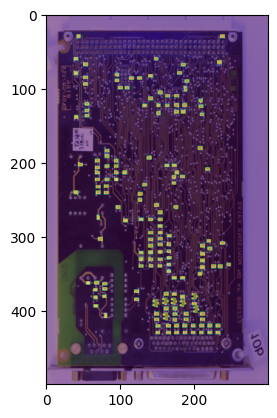

In [13]:
plt.imshow(img.cpu().numpy().transpose(1, 2, 0))
_ = plt.imshow(target['masks'].numpy().sum(axis=0).astype(bool), alpha=0.5)

In [9]:
ds_train = SemiDataset(TRAIN_PATH, train_df, resize=True, transforms=get_train_transforms())
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, 
                      num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

# Training Model

続いて、モデルの構築に移ります。

今回は、mask-cnnと呼ばれる手法を採用します。

参考：

1. https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
2. https://arxiv.org/abs/1703.06870

In [9]:
def prepare_training_model(device=DEVICE):
    model = get_model()
    model.to(DEVICE)

    for param in model.parameters():
        param.requires_grad = True

    model.train()
    return model

# Training Loop
modelまで定義ができたので、実際に学習を行います。

In [10]:
def train_one_epoch(model, dl_train, optimizer, lr_scheduler, accum_iter=ACCUM_ITER, device=DEVICE, use_scheduler=USE_SCHEDULER):
    model.train()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    n_batches = len(dl_train)
    for batch_idx, (images, targets) in tqdm(enumerate(dl_train, start=1), total=n_batches):
        # 入力および損失計算
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        # キャッシュクリア
        del images
        del targets
        torch.cuda.empty_cache()

        loss = sum(loss for loss in loss_dict.values())
        # backward
        loss.backward()
        # gradient accumulation
        if (batch_idx % ACCUM_ITER == 0) or (batch_idx == n_batches):
            optimizer.step()
            optimizer.zero_grad()

        # log
        loss_mask = loss_dict['loss_mask'].detach().item()
        loss_accum += loss.detach().item()
        loss_mask_accum += loss_mask
        if batch_idx % 4 == 0:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}")
    if USE_SCHEDULER:
        lr_scheduler.step()

    # 損失
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    return train_loss, train_loss_mask


def validate_one_epoch(model, dl_valid, device=DEVICE, pixel_th=0.5):
    model.eval()
    mAP = []
    n_batches = len(dl_valid)
    for (images, targets) in tqdm(dl_valid, total=len(dl_valid)):
        # 入力および損失計算
        images = list(image.to(DEVICE) for image in images)
        with torch.no_grad():
            preds_list = model(images)
        preds_list = [
            {k: v.cpu().numpy() for k, v in preds.items()}
            for preds in preds_list
        ]
        targets = [
            {k: v.cpu().numpy() for k, v in target.items()}
            for target in targets
        ]
        for i, preds in enumerate(preds_list):
            pred_boxes = preds['boxes']
            pred_labels = preds['labels']
            pred_scores = preds['scores']
            pred_masks = preds['masks'][:, 0, ...]
            pred_masks = (pred_masks > pixel_th).astype(int)
            ap = model_util.compute_ap_range(
                targets[i]['boxes'], targets[i]['labels'], targets[i]['masks'],
                pred_boxes, pred_labels, pred_scores, pred_masks
            )
            mAP.append(ap)
        del images
        del preds_list
        del targets
        torch.cuda.empty_cache()
    return np.mean(mAP)

In [11]:
iou_logs = collections.defaultdict(list)
cv = GroupKFold(n_splits=K_FOLD)
num_workers = cpu_count() - 1
print(f'num workers: {num_workers}')
for k, (train_idx, valid_idx) in enumerate(cv.split(train_df, groups=train_df['filename_index'].to_list())):
    print(f'fold {k + 1} / {K_FOLD} start')
    model_util.fix_all_seeds(0)
    # データローダ生成
    ds_train = SemiDataset(TRAIN_PATH, train_df.iloc[train_idx].reset_index(drop=True), transforms=get_train_transforms(), resize=True)
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, collate_fn=lambda x: tuple(zip(*x)))
    ds_valid = SemiDataset(TRAIN_PATH, train_df.iloc[valid_idx].reset_index(drop=True), transforms=None, resize=True)
    dl_valid = DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, collate_fn=lambda x: tuple(zip(*x)))

    model = prepare_training_model()

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    dst = OUTPUT / f'fold_{k + 1}' / 'best.pth'
    dst.parent.mkdir(parents=True, exist_ok=True)
    early_stopping = model_util.EarlyStopping(dst=dst, verbose=True)
    for epoch in range(1, NUM_EPOCHS + 1):
        print(f"Starting epoch {epoch} of {NUM_EPOCHS}")
        train_loss, train_loss_mask = train_one_epoch(model, dl_train, optimizer, lr_scheduler)
        valid_map = validate_one_epoch(model, dl_valid)
        print(f'train_loss={train_loss:.3f}')
        print(f'train_loss_mask={train_loss_mask:.3f}')
        print(f'valid_map={valid_map:.3f}')
        early_stopping(valid_map, model)
        if early_stopping.early_stop:
            print('early stooping!')
            break
        iou_logs[k + 1].append(valid_map)
    del model
    torch.cuda.empty_cache()

num workers: 7
fold 1 / 5 start


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   2.939. Mask-only loss:   1.109
    [Batch   8 /  86] Batch train loss:   2.271. Mask-only loss:   0.292
    [Batch  12 /  86] Batch train loss:   1.812. Mask-only loss:   0.260
    [Batch  16 /  86] Batch train loss:   2.039. Mask-only loss:   0.448
    [Batch  20 /  86] Batch train loss:   1.713. Mask-only loss:   0.189
    [Batch  24 /  86] Batch train loss:   1.689. Mask-only loss:   0.234
    [Batch  28 /  86] Batch train loss:   1.755. Mask-only loss:   0.274
    [Batch  32 /  86] Batch train loss:   1.777. Mask-only loss:   0.181
    [Batch  36 /  86] Batch train loss:   1.709. Mask-only loss:   0.281
    [Batch  40 /  86] Batch train loss:   1.752. Mask-only loss:   0.268
    [Batch  44 /  86] Batch train loss:   1.546. Mask-only loss:   0.251
    [Batch  48 /  86] Batch train loss:   2.242. Mask-only loss:   0.324
    [Batch  52 /  86] Batch train loss:   1.734. Mask-only loss:   0.184
    [Batch  56 /  86] Batch train loss:   1.914. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=2.029
train_loss_mask=0.383
valid_map=0.145
Validation score (inf --> 0.145483).  Saving model ...
Starting epoch 2 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.493. Mask-only loss:   0.206
    [Batch   8 /  86] Batch train loss:   1.346. Mask-only loss:   0.231
    [Batch  12 /  86] Batch train loss:   1.583. Mask-only loss:   0.254
    [Batch  16 /  86] Batch train loss:   1.864. Mask-only loss:   0.288
    [Batch  20 /  86] Batch train loss:   1.679. Mask-only loss:   0.272
    [Batch  24 /  86] Batch train loss:   1.552. Mask-only loss:   0.169
    [Batch  28 /  86] Batch train loss:   1.528. Mask-only loss:   0.192
    [Batch  32 /  86] Batch train loss:   1.904. Mask-only loss:   0.341
    [Batch  36 /  86] Batch train loss:   1.612. Mask-only loss:   0.224
    [Batch  40 /  86] Batch train loss:   1.463. Mask-only loss:   0.250
    [Batch  44 /  86] Batch train loss:   1.909. Mask-only loss:   0.299
    [Batch  48 /  86] Batch train loss:   1.385. Mask-only loss:   0.197
    [Batch  52 /  86] Batch train loss:   1.487. Mask-only loss:   0.226
    [Batch  56 /  86] Batch train loss:   1.613. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.533
train_loss_mask=0.227
valid_map=0.198
Validation score (0.145483 --> 0.197588).  Saving model ...
Starting epoch 3 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.193. Mask-only loss:   0.187
    [Batch   8 /  86] Batch train loss:   1.542. Mask-only loss:   0.198
    [Batch  12 /  86] Batch train loss:   1.152. Mask-only loss:   0.263
    [Batch  16 /  86] Batch train loss:   1.137. Mask-only loss:   0.146
    [Batch  20 /  86] Batch train loss:   1.633. Mask-only loss:   0.226
    [Batch  24 /  86] Batch train loss:   1.359. Mask-only loss:   0.191
    [Batch  28 /  86] Batch train loss:   1.567. Mask-only loss:   0.215
    [Batch  32 /  86] Batch train loss:   1.476. Mask-only loss:   0.173
    [Batch  36 /  86] Batch train loss:   1.266. Mask-only loss:   0.190
    [Batch  40 /  86] Batch train loss:   0.976. Mask-only loss:   0.139
    [Batch  44 /  86] Batch train loss:   1.289. Mask-only loss:   0.207
    [Batch  48 /  86] Batch train loss:   2.098. Mask-only loss:   0.348
    [Batch  52 /  86] Batch train loss:   1.403. Mask-only loss:   0.162
    [Batch  56 /  86] Batch train loss:   1.540. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.403
train_loss_mask=0.210
valid_map=0.229
Validation score (0.197588 --> 0.229465).  Saving model ...
Starting epoch 4 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.272. Mask-only loss:   0.204
    [Batch   8 /  86] Batch train loss:   1.529. Mask-only loss:   0.198
    [Batch  12 /  86] Batch train loss:   1.277. Mask-only loss:   0.186
    [Batch  16 /  86] Batch train loss:   1.310. Mask-only loss:   0.179
    [Batch  20 /  86] Batch train loss:   1.542. Mask-only loss:   0.220
    [Batch  24 /  86] Batch train loss:   1.423. Mask-only loss:   0.198
    [Batch  28 /  86] Batch train loss:   1.318. Mask-only loss:   0.232
    [Batch  32 /  86] Batch train loss:   1.156. Mask-only loss:   0.157
    [Batch  36 /  86] Batch train loss:   1.326. Mask-only loss:   0.189
    [Batch  40 /  86] Batch train loss:   1.343. Mask-only loss:   0.176
    [Batch  44 /  86] Batch train loss:   1.540. Mask-only loss:   0.191
    [Batch  48 /  86] Batch train loss:   1.045. Mask-only loss:   0.125
    [Batch  52 /  86] Batch train loss:   1.379. Mask-only loss:   0.204
    [Batch  56 /  86] Batch train loss:   1.285. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.320
train_loss_mask=0.201
valid_map=0.267
Validation score (0.229465 --> 0.267153).  Saving model ...
Starting epoch 5 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.262. Mask-only loss:   0.196
    [Batch   8 /  86] Batch train loss:   1.455. Mask-only loss:   0.255
    [Batch  12 /  86] Batch train loss:   1.201. Mask-only loss:   0.207
    [Batch  16 /  86] Batch train loss:   1.184. Mask-only loss:   0.142
    [Batch  20 /  86] Batch train loss:   1.397. Mask-only loss:   0.226
    [Batch  24 /  86] Batch train loss:   1.201. Mask-only loss:   0.206
    [Batch  28 /  86] Batch train loss:   1.095. Mask-only loss:   0.178
    [Batch  32 /  86] Batch train loss:   1.019. Mask-only loss:   0.121
    [Batch  36 /  86] Batch train loss:   1.272. Mask-only loss:   0.230
    [Batch  40 /  86] Batch train loss:   1.119. Mask-only loss:   0.175
    [Batch  44 /  86] Batch train loss:   1.360. Mask-only loss:   0.273
    [Batch  48 /  86] Batch train loss:   1.278. Mask-only loss:   0.251
    [Batch  52 /  86] Batch train loss:   1.261. Mask-only loss:   0.177
    [Batch  56 /  86] Batch train loss:   1.579. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.243
train_loss_mask=0.195
valid_map=0.264
EarlyStopping counter: 1 out of 5
Starting epoch 6 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.373. Mask-only loss:   0.184
    [Batch   8 /  86] Batch train loss:   1.314. Mask-only loss:   0.218
    [Batch  12 /  86] Batch train loss:   1.101. Mask-only loss:   0.151
    [Batch  16 /  86] Batch train loss:   1.335. Mask-only loss:   0.224
    [Batch  20 /  86] Batch train loss:   1.223. Mask-only loss:   0.181
    [Batch  24 /  86] Batch train loss:   1.097. Mask-only loss:   0.194
    [Batch  28 /  86] Batch train loss:   1.246. Mask-only loss:   0.173
    [Batch  32 /  86] Batch train loss:   1.260. Mask-only loss:   0.191
    [Batch  36 /  86] Batch train loss:   1.413. Mask-only loss:   0.165
    [Batch  40 /  86] Batch train loss:   1.218. Mask-only loss:   0.236
    [Batch  44 /  86] Batch train loss:   1.360. Mask-only loss:   0.163
    [Batch  48 /  86] Batch train loss:   0.997. Mask-only loss:   0.191
    [Batch  52 /  86] Batch train loss:   1.106. Mask-only loss:   0.160
    [Batch  56 /  86] Batch train loss:   1.344. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.190
train_loss_mask=0.184
valid_map=0.269
Validation score (0.267153 --> 0.268838).  Saving model ...
Starting epoch 7 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.046. Mask-only loss:   0.206
    [Batch   8 /  86] Batch train loss:   1.301. Mask-only loss:   0.177
    [Batch  12 /  86] Batch train loss:   1.228. Mask-only loss:   0.184
    [Batch  16 /  86] Batch train loss:   1.374. Mask-only loss:   0.151
    [Batch  20 /  86] Batch train loss:   1.115. Mask-only loss:   0.170
    [Batch  24 /  86] Batch train loss:   1.220. Mask-only loss:   0.154
    [Batch  28 /  86] Batch train loss:   1.263. Mask-only loss:   0.200
    [Batch  32 /  86] Batch train loss:   1.145. Mask-only loss:   0.210
    [Batch  36 /  86] Batch train loss:   0.972. Mask-only loss:   0.144
    [Batch  40 /  86] Batch train loss:   1.087. Mask-only loss:   0.168
    [Batch  44 /  86] Batch train loss:   0.988. Mask-only loss:   0.170
    [Batch  48 /  86] Batch train loss:   1.184. Mask-only loss:   0.154
    [Batch  52 /  86] Batch train loss:   1.103. Mask-only loss:   0.144
    [Batch  56 /  86] Batch train loss:   1.221. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.144
train_loss_mask=0.180
valid_map=0.297
Validation score (0.268838 --> 0.297408).  Saving model ...
Starting epoch 8 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.083. Mask-only loss:   0.179
    [Batch   8 /  86] Batch train loss:   1.207. Mask-only loss:   0.190
    [Batch  12 /  86] Batch train loss:   1.164. Mask-only loss:   0.191
    [Batch  16 /  86] Batch train loss:   1.113. Mask-only loss:   0.201
    [Batch  20 /  86] Batch train loss:   1.110. Mask-only loss:   0.156
    [Batch  24 /  86] Batch train loss:   1.108. Mask-only loss:   0.169
    [Batch  28 /  86] Batch train loss:   0.971. Mask-only loss:   0.199
    [Batch  32 /  86] Batch train loss:   0.835. Mask-only loss:   0.158
    [Batch  36 /  86] Batch train loss:   1.105. Mask-only loss:   0.161
    [Batch  40 /  86] Batch train loss:   1.060. Mask-only loss:   0.204
    [Batch  44 /  86] Batch train loss:   1.043. Mask-only loss:   0.135
    [Batch  48 /  86] Batch train loss:   1.309. Mask-only loss:   0.231
    [Batch  52 /  86] Batch train loss:   0.882. Mask-only loss:   0.149
    [Batch  56 /  86] Batch train loss:   1.030. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.105
train_loss_mask=0.176
valid_map=0.276
EarlyStopping counter: 1 out of 5
Starting epoch 9 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.866. Mask-only loss:   0.148
    [Batch   8 /  86] Batch train loss:   0.957. Mask-only loss:   0.123
    [Batch  12 /  86] Batch train loss:   1.020. Mask-only loss:   0.132
    [Batch  16 /  86] Batch train loss:   1.247. Mask-only loss:   0.234
    [Batch  20 /  86] Batch train loss:   1.043. Mask-only loss:   0.149
    [Batch  24 /  86] Batch train loss:   1.108. Mask-only loss:   0.179
    [Batch  28 /  86] Batch train loss:   0.990. Mask-only loss:   0.140
    [Batch  32 /  86] Batch train loss:   1.325. Mask-only loss:   0.161
    [Batch  36 /  86] Batch train loss:   1.190. Mask-only loss:   0.159
    [Batch  40 /  86] Batch train loss:   1.213. Mask-only loss:   0.171
    [Batch  44 /  86] Batch train loss:   1.318. Mask-only loss:   0.195
    [Batch  48 /  86] Batch train loss:   0.927. Mask-only loss:   0.172
    [Batch  52 /  86] Batch train loss:   0.969. Mask-only loss:   0.173
    [Batch  56 /  86] Batch train loss:   1.048. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.118
train_loss_mask=0.180
valid_map=0.285
EarlyStopping counter: 2 out of 5
Starting epoch 10 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.032. Mask-only loss:   0.187
    [Batch   8 /  86] Batch train loss:   1.171. Mask-only loss:   0.151
    [Batch  12 /  86] Batch train loss:   1.443. Mask-only loss:   0.196
    [Batch  16 /  86] Batch train loss:   1.341. Mask-only loss:   0.244
    [Batch  20 /  86] Batch train loss:   0.918. Mask-only loss:   0.174
    [Batch  24 /  86] Batch train loss:   1.213. Mask-only loss:   0.212
    [Batch  28 /  86] Batch train loss:   0.749. Mask-only loss:   0.127
    [Batch  32 /  86] Batch train loss:   1.177. Mask-only loss:   0.161
    [Batch  36 /  86] Batch train loss:   0.817. Mask-only loss:   0.134
    [Batch  40 /  86] Batch train loss:   1.029. Mask-only loss:   0.179
    [Batch  44 /  86] Batch train loss:   0.783. Mask-only loss:   0.124
    [Batch  48 /  86] Batch train loss:   1.168. Mask-only loss:   0.152
    [Batch  52 /  86] Batch train loss:   1.279. Mask-only loss:   0.176
    [Batch  56 /  86] Batch train loss:   1.062. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.085
train_loss_mask=0.178
valid_map=0.271
EarlyStopping counter: 3 out of 5
Starting epoch 11 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.288. Mask-only loss:   0.201
    [Batch   8 /  86] Batch train loss:   1.210. Mask-only loss:   0.187
    [Batch  12 /  86] Batch train loss:   0.952. Mask-only loss:   0.130
    [Batch  16 /  86] Batch train loss:   0.903. Mask-only loss:   0.135
    [Batch  20 /  86] Batch train loss:   1.138. Mask-only loss:   0.209
    [Batch  24 /  86] Batch train loss:   0.829. Mask-only loss:   0.163
    [Batch  28 /  86] Batch train loss:   0.873. Mask-only loss:   0.134
    [Batch  32 /  86] Batch train loss:   0.911. Mask-only loss:   0.150
    [Batch  36 /  86] Batch train loss:   1.320. Mask-only loss:   0.173
    [Batch  40 /  86] Batch train loss:   1.059. Mask-only loss:   0.172
    [Batch  44 /  86] Batch train loss:   0.874. Mask-only loss:   0.169
    [Batch  48 /  86] Batch train loss:   1.081. Mask-only loss:   0.195
    [Batch  52 /  86] Batch train loss:   0.650. Mask-only loss:   0.108
    [Batch  56 /  86] Batch train loss:   1.172. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.049
train_loss_mask=0.171
valid_map=0.288
EarlyStopping counter: 4 out of 5
Starting epoch 12 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.027. Mask-only loss:   0.145
    [Batch   8 /  86] Batch train loss:   1.073. Mask-only loss:   0.160
    [Batch  12 /  86] Batch train loss:   0.979. Mask-only loss:   0.128
    [Batch  16 /  86] Batch train loss:   1.037. Mask-only loss:   0.182
    [Batch  20 /  86] Batch train loss:   0.699. Mask-only loss:   0.141
    [Batch  24 /  86] Batch train loss:   1.075. Mask-only loss:   0.189
    [Batch  28 /  86] Batch train loss:   0.901. Mask-only loss:   0.183
    [Batch  32 /  86] Batch train loss:   1.825. Mask-only loss:   0.418
    [Batch  36 /  86] Batch train loss:   0.693. Mask-only loss:   0.101
    [Batch  40 /  86] Batch train loss:   0.783. Mask-only loss:   0.116
    [Batch  44 /  86] Batch train loss:   1.004. Mask-only loss:   0.150
    [Batch  48 /  86] Batch train loss:   1.067. Mask-only loss:   0.144
    [Batch  52 /  86] Batch train loss:   0.792. Mask-only loss:   0.113
    [Batch  56 /  86] Batch train loss:   1.063. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.069
train_loss_mask=0.169
valid_map=0.291
EarlyStopping counter: 5 out of 5
early stooping!
fold 2 / 5 start


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   3.143. Mask-only loss:   1.044
    [Batch   8 /  86] Batch train loss:   2.266. Mask-only loss:   0.365
    [Batch  12 /  86] Batch train loss:   1.923. Mask-only loss:   0.391
    [Batch  16 /  86] Batch train loss:   2.027. Mask-only loss:   0.358
    [Batch  20 /  86] Batch train loss:   2.164. Mask-only loss:   0.375
    [Batch  24 /  86] Batch train loss:   2.116. Mask-only loss:   0.297
    [Batch  28 /  86] Batch train loss:   1.839. Mask-only loss:   0.322
    [Batch  32 /  86] Batch train loss:   1.569. Mask-only loss:   0.206
    [Batch  36 /  86] Batch train loss:   1.770. Mask-only loss:   0.231
    [Batch  40 /  86] Batch train loss:   1.740. Mask-only loss:   0.138
    [Batch  44 /  86] Batch train loss:   2.719. Mask-only loss:   0.448
    [Batch  48 /  86] Batch train loss:   1.594. Mask-only loss:   0.246
    [Batch  52 /  86] Batch train loss:   1.350. Mask-only loss:   0.215
    [Batch  56 /  86] Batch train loss:   1.867. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.963
train_loss_mask=0.374
valid_map=0.093
Validation score (inf --> 0.093362).  Saving model ...
Starting epoch 2 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.620. Mask-only loss:   0.265
    [Batch   8 /  86] Batch train loss:   1.486. Mask-only loss:   0.197
    [Batch  12 /  86] Batch train loss:   1.819. Mask-only loss:   0.217
    [Batch  16 /  86] Batch train loss:   1.569. Mask-only loss:   0.229
    [Batch  20 /  86] Batch train loss:   2.469. Mask-only loss:   0.325
    [Batch  24 /  86] Batch train loss:   1.412. Mask-only loss:   0.190
    [Batch  28 /  86] Batch train loss:   1.471. Mask-only loss:   0.174
    [Batch  32 /  86] Batch train loss:   1.372. Mask-only loss:   0.160
    [Batch  36 /  86] Batch train loss:   1.456. Mask-only loss:   0.331
    [Batch  40 /  86] Batch train loss:   1.229. Mask-only loss:   0.196
    [Batch  44 /  86] Batch train loss:   1.566. Mask-only loss:   0.268
    [Batch  48 /  86] Batch train loss:   1.824. Mask-only loss:   0.305
    [Batch  52 /  86] Batch train loss:   1.496. Mask-only loss:   0.213
    [Batch  56 /  86] Batch train loss:   1.508. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.486
train_loss_mask=0.218
valid_map=0.134
Validation score (0.093362 --> 0.134163).  Saving model ...
Starting epoch 3 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.518. Mask-only loss:   0.236
    [Batch   8 /  86] Batch train loss:   1.399. Mask-only loss:   0.193
    [Batch  12 /  86] Batch train loss:   1.166. Mask-only loss:   0.315
    [Batch  16 /  86] Batch train loss:   1.322. Mask-only loss:   0.150
    [Batch  20 /  86] Batch train loss:   1.590. Mask-only loss:   0.229
    [Batch  24 /  86] Batch train loss:   1.583. Mask-only loss:   0.210
    [Batch  28 /  86] Batch train loss:   1.406. Mask-only loss:   0.230
    [Batch  32 /  86] Batch train loss:   1.187. Mask-only loss:   0.200
    [Batch  36 /  86] Batch train loss:   1.248. Mask-only loss:   0.201
    [Batch  40 /  86] Batch train loss:   1.000. Mask-only loss:   0.138
    [Batch  44 /  86] Batch train loss:   1.215. Mask-only loss:   0.189
    [Batch  48 /  86] Batch train loss:   1.184. Mask-only loss:   0.133
    [Batch  52 /  86] Batch train loss:   1.390. Mask-only loss:   0.189
    [Batch  56 /  86] Batch train loss:   1.320. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.331
train_loss_mask=0.203
valid_map=0.140
Validation score (0.134163 --> 0.140410).  Saving model ...
Starting epoch 4 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.514. Mask-only loss:   0.225
    [Batch   8 /  86] Batch train loss:   1.493. Mask-only loss:   0.164
    [Batch  12 /  86] Batch train loss:   1.156. Mask-only loss:   0.152
    [Batch  16 /  86] Batch train loss:   1.278. Mask-only loss:   0.150
    [Batch  20 /  86] Batch train loss:   1.431. Mask-only loss:   0.213
    [Batch  24 /  86] Batch train loss:   1.244. Mask-only loss:   0.207
    [Batch  28 /  86] Batch train loss:   1.504. Mask-only loss:   0.206
    [Batch  32 /  86] Batch train loss:   1.150. Mask-only loss:   0.141
    [Batch  36 /  86] Batch train loss:   1.056. Mask-only loss:   0.133
    [Batch  40 /  86] Batch train loss:   1.313. Mask-only loss:   0.150
    [Batch  44 /  86] Batch train loss:   1.144. Mask-only loss:   0.164
    [Batch  48 /  86] Batch train loss:   0.901. Mask-only loss:   0.152
    [Batch  52 /  86] Batch train loss:   1.502. Mask-only loss:   0.429
    [Batch  56 /  86] Batch train loss:   1.281. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.254
train_loss_mask=0.192
valid_map=0.142
Validation score (0.140410 --> 0.141691).  Saving model ...
Starting epoch 5 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   2.072. Mask-only loss:   0.222
    [Batch   8 /  86] Batch train loss:   1.416. Mask-only loss:   0.251
    [Batch  12 /  86] Batch train loss:   1.256. Mask-only loss:   0.181
    [Batch  16 /  86] Batch train loss:   1.148. Mask-only loss:   0.136
    [Batch  20 /  86] Batch train loss:   1.301. Mask-only loss:   0.206
    [Batch  24 /  86] Batch train loss:   1.153. Mask-only loss:   0.181
    [Batch  28 /  86] Batch train loss:   1.189. Mask-only loss:   0.242
    [Batch  32 /  86] Batch train loss:   0.968. Mask-only loss:   0.114
    [Batch  36 /  86] Batch train loss:   1.002. Mask-only loss:   0.164
    [Batch  40 /  86] Batch train loss:   1.085. Mask-only loss:   0.193
    [Batch  44 /  86] Batch train loss:   0.990. Mask-only loss:   0.213
    [Batch  48 /  86] Batch train loss:   1.024. Mask-only loss:   0.156
    [Batch  52 /  86] Batch train loss:   1.149. Mask-only loss:   0.166
    [Batch  56 /  86] Batch train loss:   0.870. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.201
train_loss_mask=0.186
valid_map=0.164
Validation score (0.141691 --> 0.163811).  Saving model ...
Starting epoch 6 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.514. Mask-only loss:   0.301
    [Batch   8 /  86] Batch train loss:   1.404. Mask-only loss:   0.227
    [Batch  12 /  86] Batch train loss:   1.158. Mask-only loss:   0.154
    [Batch  16 /  86] Batch train loss:   1.336. Mask-only loss:   0.195
    [Batch  20 /  86] Batch train loss:   1.276. Mask-only loss:   0.221
    [Batch  24 /  86] Batch train loss:   0.975. Mask-only loss:   0.190
    [Batch  28 /  86] Batch train loss:   1.082. Mask-only loss:   0.146
    [Batch  32 /  86] Batch train loss:   0.480. Mask-only loss:   0.193
    [Batch  36 /  86] Batch train loss:   1.018. Mask-only loss:   0.125
    [Batch  40 /  86] Batch train loss:   1.303. Mask-only loss:   0.193
    [Batch  44 /  86] Batch train loss:   1.164. Mask-only loss:   0.188
    [Batch  48 /  86] Batch train loss:   1.130. Mask-only loss:   0.157
    [Batch  52 /  86] Batch train loss:   0.998. Mask-only loss:   0.182
    [Batch  56 /  86] Batch train loss:   1.441. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.124
train_loss_mask=0.178
valid_map=0.163
EarlyStopping counter: 1 out of 5
Starting epoch 7 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.955. Mask-only loss:   0.126
    [Batch   8 /  86] Batch train loss:   1.211. Mask-only loss:   0.186
    [Batch  12 /  86] Batch train loss:   1.306. Mask-only loss:   0.201
    [Batch  16 /  86] Batch train loss:   1.053. Mask-only loss:   0.160
    [Batch  20 /  86] Batch train loss:   1.212. Mask-only loss:   0.192
    [Batch  24 /  86] Batch train loss:   1.219. Mask-only loss:   0.169
    [Batch  28 /  86] Batch train loss:   1.132. Mask-only loss:   0.178
    [Batch  32 /  86] Batch train loss:   1.480. Mask-only loss:   0.221
    [Batch  36 /  86] Batch train loss:   0.916. Mask-only loss:   0.124
    [Batch  40 /  86] Batch train loss:   0.954. Mask-only loss:   0.154
    [Batch  44 /  86] Batch train loss:   1.058. Mask-only loss:   0.181
    [Batch  48 /  86] Batch train loss:   1.107. Mask-only loss:   0.162
    [Batch  52 /  86] Batch train loss:   0.998. Mask-only loss:   0.132
    [Batch  56 /  86] Batch train loss:   1.264. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.086
train_loss_mask=0.171
valid_map=0.178
Validation score (0.163811 --> 0.177893).  Saving model ...
Starting epoch 8 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.961. Mask-only loss:   0.159
    [Batch   8 /  86] Batch train loss:   1.233. Mask-only loss:   0.180
    [Batch  12 /  86] Batch train loss:   1.083. Mask-only loss:   0.200
    [Batch  16 /  86] Batch train loss:   1.095. Mask-only loss:   0.179
    [Batch  20 /  86] Batch train loss:   1.149. Mask-only loss:   0.145
    [Batch  24 /  86] Batch train loss:   0.926. Mask-only loss:   0.139
    [Batch  28 /  86] Batch train loss:   1.147. Mask-only loss:   0.214
    [Batch  32 /  86] Batch train loss:   0.871. Mask-only loss:   0.156
    [Batch  36 /  86] Batch train loss:   1.091. Mask-only loss:   0.174
    [Batch  40 /  86] Batch train loss:   1.163. Mask-only loss:   0.162
    [Batch  44 /  86] Batch train loss:   0.972. Mask-only loss:   0.133
    [Batch  48 /  86] Batch train loss:   1.512. Mask-only loss:   0.188
    [Batch  52 /  86] Batch train loss:   0.930. Mask-only loss:   0.151
    [Batch  56 /  86] Batch train loss:   0.882. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.046
train_loss_mask=0.169
valid_map=0.172
EarlyStopping counter: 1 out of 5
Starting epoch 9 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.929. Mask-only loss:   0.163
    [Batch   8 /  86] Batch train loss:   0.929. Mask-only loss:   0.138
    [Batch  12 /  86] Batch train loss:   0.901. Mask-only loss:   0.097
    [Batch  16 /  86] Batch train loss:   1.327. Mask-only loss:   0.203
    [Batch  20 /  86] Batch train loss:   0.661. Mask-only loss:   0.109
    [Batch  24 /  86] Batch train loss:   1.353. Mask-only loss:   0.184
    [Batch  28 /  86] Batch train loss:   0.744. Mask-only loss:   0.148
    [Batch  32 /  86] Batch train loss:   1.076. Mask-only loss:   0.171
    [Batch  36 /  86] Batch train loss:   0.930. Mask-only loss:   0.149
    [Batch  40 /  86] Batch train loss:   1.061. Mask-only loss:   0.186
    [Batch  44 /  86] Batch train loss:   0.341. Mask-only loss:   0.129
    [Batch  48 /  86] Batch train loss:   0.793. Mask-only loss:   0.131
    [Batch  52 /  86] Batch train loss:   0.893. Mask-only loss:   0.164
    [Batch  56 /  86] Batch train loss:   1.059. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.032
train_loss_mask=0.174
valid_map=0.189
Validation score (0.177893 --> 0.189017).  Saving model ...
Starting epoch 10 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.888. Mask-only loss:   0.152
    [Batch   8 /  86] Batch train loss:   0.990. Mask-only loss:   0.140
    [Batch  12 /  86] Batch train loss:   0.987. Mask-only loss:   0.133
    [Batch  16 /  86] Batch train loss:   0.959. Mask-only loss:   0.187
    [Batch  20 /  86] Batch train loss:   0.959. Mask-only loss:   0.150
    [Batch  24 /  86] Batch train loss:   0.872. Mask-only loss:   0.168
    [Batch  28 /  86] Batch train loss:   0.803. Mask-only loss:   0.101
    [Batch  32 /  86] Batch train loss:   1.657. Mask-only loss:   0.227
    [Batch  36 /  86] Batch train loss:   1.471. Mask-only loss:   0.338
    [Batch  40 /  86] Batch train loss:   1.226. Mask-only loss:   0.174
    [Batch  44 /  86] Batch train loss:   0.855. Mask-only loss:   0.132
    [Batch  48 /  86] Batch train loss:   1.057. Mask-only loss:   0.157
    [Batch  52 /  86] Batch train loss:   0.963. Mask-only loss:   0.156
    [Batch  56 /  86] Batch train loss:   0.878. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=1.019
train_loss_mask=0.169
valid_map=0.177
EarlyStopping counter: 1 out of 5
Starting epoch 11 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.092. Mask-only loss:   0.187
    [Batch   8 /  86] Batch train loss:   1.061. Mask-only loss:   0.181
    [Batch  12 /  86] Batch train loss:   1.063. Mask-only loss:   0.202
    [Batch  16 /  86] Batch train loss:   0.924. Mask-only loss:   0.159
    [Batch  20 /  86] Batch train loss:   0.953. Mask-only loss:   0.155
    [Batch  24 /  86] Batch train loss:   0.982. Mask-only loss:   0.133
    [Batch  28 /  86] Batch train loss:   0.887. Mask-only loss:   0.133
    [Batch  32 /  86] Batch train loss:   0.834. Mask-only loss:   0.147
    [Batch  36 /  86] Batch train loss:   1.224. Mask-only loss:   0.280
    [Batch  40 /  86] Batch train loss:   1.317. Mask-only loss:   0.211
    [Batch  44 /  86] Batch train loss:   0.840. Mask-only loss:   0.124
    [Batch  48 /  86] Batch train loss:   0.508. Mask-only loss:   0.195
    [Batch  52 /  86] Batch train loss:   0.763. Mask-only loss:   0.107
    [Batch  56 /  86] Batch train loss:   1.324. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.998
train_loss_mask=0.165
valid_map=0.191
Validation score (0.189017 --> 0.190540).  Saving model ...
Starting epoch 12 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.122. Mask-only loss:   0.177
    [Batch   8 /  86] Batch train loss:   0.452. Mask-only loss:   0.189
    [Batch  12 /  86] Batch train loss:   1.033. Mask-only loss:   0.139
    [Batch  16 /  86] Batch train loss:   0.931. Mask-only loss:   0.178
    [Batch  20 /  86] Batch train loss:   1.113. Mask-only loss:   0.284
    [Batch  24 /  86] Batch train loss:   0.961. Mask-only loss:   0.141
    [Batch  28 /  86] Batch train loss:   0.813. Mask-only loss:   0.146
    [Batch  32 /  86] Batch train loss:   1.089. Mask-only loss:   0.198
    [Batch  36 /  86] Batch train loss:   0.749. Mask-only loss:   0.111
    [Batch  40 /  86] Batch train loss:   0.666. Mask-only loss:   0.113
    [Batch  44 /  86] Batch train loss:   0.913. Mask-only loss:   0.096
    [Batch  48 /  86] Batch train loss:   0.967. Mask-only loss:   0.142
    [Batch  52 /  86] Batch train loss:   0.656. Mask-only loss:   0.120
    [Batch  56 /  86] Batch train loss:   0.978. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.962
train_loss_mask=0.160
valid_map=0.194
Validation score (0.190540 --> 0.193839).  Saving model ...
Starting epoch 13 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.172. Mask-only loss:   0.174
    [Batch   8 /  86] Batch train loss:   0.936. Mask-only loss:   0.151
    [Batch  12 /  86] Batch train loss:   1.054. Mask-only loss:   0.148
    [Batch  16 /  86] Batch train loss:   0.965. Mask-only loss:   0.158
    [Batch  20 /  86] Batch train loss:   0.871. Mask-only loss:   0.125
    [Batch  24 /  86] Batch train loss:   0.977. Mask-only loss:   0.135
    [Batch  28 /  86] Batch train loss:   0.842. Mask-only loss:   0.117
    [Batch  32 /  86] Batch train loss:   1.235. Mask-only loss:   0.194
    [Batch  36 /  86] Batch train loss:   0.968. Mask-only loss:   0.149
    [Batch  40 /  86] Batch train loss:   1.046. Mask-only loss:   0.137
    [Batch  44 /  86] Batch train loss:   0.884. Mask-only loss:   0.125
    [Batch  48 /  86] Batch train loss:   0.770. Mask-only loss:   0.126
    [Batch  52 /  86] Batch train loss:   0.847. Mask-only loss:   0.168
    [Batch  56 /  86] Batch train loss:   0.662. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.983
train_loss_mask=0.158
valid_map=0.218
Validation score (0.193839 --> 0.217567).  Saving model ...
Starting epoch 14 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.141. Mask-only loss:   0.170
    [Batch   8 /  86] Batch train loss:   1.047. Mask-only loss:   0.234
    [Batch  12 /  86] Batch train loss:   0.908. Mask-only loss:   0.136
    [Batch  16 /  86] Batch train loss:   0.879. Mask-only loss:   0.146
    [Batch  20 /  86] Batch train loss:   1.244. Mask-only loss:   0.166
    [Batch  24 /  86] Batch train loss:   0.873. Mask-only loss:   0.156
    [Batch  28 /  86] Batch train loss:   0.844. Mask-only loss:   0.106
    [Batch  32 /  86] Batch train loss:   1.353. Mask-only loss:   0.177
    [Batch  36 /  86] Batch train loss:   0.979. Mask-only loss:   0.149
    [Batch  40 /  86] Batch train loss:   1.081. Mask-only loss:   0.150
    [Batch  44 /  86] Batch train loss:   1.083. Mask-only loss:   0.188
    [Batch  48 /  86] Batch train loss:   1.087. Mask-only loss:   0.164
    [Batch  52 /  86] Batch train loss:   0.781. Mask-only loss:   0.104
    [Batch  56 /  86] Batch train loss:   1.065. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.959
train_loss_mask=0.157
valid_map=0.196
EarlyStopping counter: 1 out of 5
Starting epoch 15 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.993. Mask-only loss:   0.185
    [Batch   8 /  86] Batch train loss:   1.100. Mask-only loss:   0.250
    [Batch  12 /  86] Batch train loss:   1.056. Mask-only loss:   0.157
    [Batch  16 /  86] Batch train loss:   1.215. Mask-only loss:   0.171
    [Batch  20 /  86] Batch train loss:   1.269. Mask-only loss:   0.177
    [Batch  24 /  86] Batch train loss:   0.923. Mask-only loss:   0.150
    [Batch  28 /  86] Batch train loss:   0.740. Mask-only loss:   0.149
    [Batch  32 /  86] Batch train loss:   1.149. Mask-only loss:   0.172
    [Batch  36 /  86] Batch train loss:   0.815. Mask-only loss:   0.149
    [Batch  40 /  86] Batch train loss:   0.839. Mask-only loss:   0.152
    [Batch  44 /  86] Batch train loss:   0.405. Mask-only loss:   0.211
    [Batch  48 /  86] Batch train loss:   0.875. Mask-only loss:   0.141
    [Batch  52 /  86] Batch train loss:   0.999. Mask-only loss:   0.126
    [Batch  56 /  86] Batch train loss:   0.957. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.927
train_loss_mask=0.159
valid_map=0.211
EarlyStopping counter: 2 out of 5
Starting epoch 16 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.727. Mask-only loss:   0.136
    [Batch   8 /  86] Batch train loss:   0.707. Mask-only loss:   0.117
    [Batch  12 /  86] Batch train loss:   1.243. Mask-only loss:   0.237
    [Batch  16 /  86] Batch train loss:   1.067. Mask-only loss:   0.152
    [Batch  20 /  86] Batch train loss:   0.705. Mask-only loss:   0.120
    [Batch  24 /  86] Batch train loss:   0.936. Mask-only loss:   0.150
    [Batch  28 /  86] Batch train loss:   0.905. Mask-only loss:   0.178
    [Batch  32 /  86] Batch train loss:   0.949. Mask-only loss:   0.153
    [Batch  36 /  86] Batch train loss:   1.269. Mask-only loss:   0.199
    [Batch  40 /  86] Batch train loss:   0.901. Mask-only loss:   0.170
    [Batch  44 /  86] Batch train loss:   0.899. Mask-only loss:   0.137
    [Batch  48 /  86] Batch train loss:   0.870. Mask-only loss:   0.190
    [Batch  52 /  86] Batch train loss:   0.757. Mask-only loss:   0.160
    [Batch  56 /  86] Batch train loss:   0.703. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.900
train_loss_mask=0.158
valid_map=0.229
Validation score (0.217567 --> 0.229131).  Saving model ...
Starting epoch 17 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.794. Mask-only loss:   0.121
    [Batch   8 /  86] Batch train loss:   0.777. Mask-only loss:   0.122
    [Batch  12 /  86] Batch train loss:   1.004. Mask-only loss:   0.133
    [Batch  16 /  86] Batch train loss:   0.762. Mask-only loss:   0.206
    [Batch  20 /  86] Batch train loss:   0.231. Mask-only loss:   0.099
    [Batch  24 /  86] Batch train loss:   0.996. Mask-only loss:   0.146
    [Batch  28 /  86] Batch train loss:   1.212. Mask-only loss:   0.170
    [Batch  32 /  86] Batch train loss:   1.042. Mask-only loss:   0.188
    [Batch  36 /  86] Batch train loss:   0.890. Mask-only loss:   0.141
    [Batch  40 /  86] Batch train loss:   1.190. Mask-only loss:   0.160
    [Batch  44 /  86] Batch train loss:   0.769. Mask-only loss:   0.093
    [Batch  48 /  86] Batch train loss:   0.888. Mask-only loss:   0.142
    [Batch  52 /  86] Batch train loss:   0.942. Mask-only loss:   0.127
    [Batch  56 /  86] Batch train loss:   0.875. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.896
train_loss_mask=0.150
valid_map=0.198
EarlyStopping counter: 1 out of 5
Starting epoch 18 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.246. Mask-only loss:   0.110
    [Batch   8 /  86] Batch train loss:   0.968. Mask-only loss:   0.147
    [Batch  12 /  86] Batch train loss:   0.812. Mask-only loss:   0.173
    [Batch  16 /  86] Batch train loss:   0.866. Mask-only loss:   0.125
    [Batch  20 /  86] Batch train loss:   0.753. Mask-only loss:   0.151
    [Batch  24 /  86] Batch train loss:   0.682. Mask-only loss:   0.145
    [Batch  28 /  86] Batch train loss:   0.936. Mask-only loss:   0.141
    [Batch  32 /  86] Batch train loss:   1.140. Mask-only loss:   0.169
    [Batch  36 /  86] Batch train loss:   0.771. Mask-only loss:   0.127
    [Batch  40 /  86] Batch train loss:   0.912. Mask-only loss:   0.164
    [Batch  44 /  86] Batch train loss:   0.770. Mask-only loss:   0.133
    [Batch  48 /  86] Batch train loss:   0.780. Mask-only loss:   0.132
    [Batch  52 /  86] Batch train loss:   0.968. Mask-only loss:   0.200
    [Batch  56 /  86] Batch train loss:   0.979. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.877
train_loss_mask=0.148
valid_map=0.237
Validation score (0.229131 --> 0.236528).  Saving model ...
Starting epoch 19 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.955. Mask-only loss:   0.128
    [Batch   8 /  86] Batch train loss:   0.941. Mask-only loss:   0.149
    [Batch  12 /  86] Batch train loss:   0.944. Mask-only loss:   0.129
    [Batch  16 /  86] Batch train loss:   0.714. Mask-only loss:   0.116
    [Batch  20 /  86] Batch train loss:   0.944. Mask-only loss:   0.128
    [Batch  24 /  86] Batch train loss:   0.986. Mask-only loss:   0.256
    [Batch  28 /  86] Batch train loss:   0.869. Mask-only loss:   0.129
    [Batch  32 /  86] Batch train loss:   0.842. Mask-only loss:   0.143
    [Batch  36 /  86] Batch train loss:   0.687. Mask-only loss:   0.114
    [Batch  40 /  86] Batch train loss:   1.158. Mask-only loss:   0.167
    [Batch  44 /  86] Batch train loss:   0.253. Mask-only loss:   0.094
    [Batch  48 /  86] Batch train loss:   0.707. Mask-only loss:   0.115
    [Batch  52 /  86] Batch train loss:   1.214. Mask-only loss:   0.164
    [Batch  56 /  86] Batch train loss:   0.681. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.868
train_loss_mask=0.150
valid_map=0.201
EarlyStopping counter: 1 out of 5
Starting epoch 20 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.803. Mask-only loss:   0.114
    [Batch   8 /  86] Batch train loss:   0.798. Mask-only loss:   0.130
    [Batch  12 /  86] Batch train loss:   1.146. Mask-only loss:   0.185
    [Batch  16 /  86] Batch train loss:   0.784. Mask-only loss:   0.130
    [Batch  20 /  86] Batch train loss:   0.993. Mask-only loss:   0.160
    [Batch  24 /  86] Batch train loss:   0.870. Mask-only loss:   0.174
    [Batch  28 /  86] Batch train loss:   0.954. Mask-only loss:   0.154
    [Batch  32 /  86] Batch train loss:   0.724. Mask-only loss:   0.154
    [Batch  36 /  86] Batch train loss:   1.001. Mask-only loss:   0.128
    [Batch  40 /  86] Batch train loss:   0.945. Mask-only loss:   0.159
    [Batch  44 /  86] Batch train loss:   0.839. Mask-only loss:   0.198
    [Batch  48 /  86] Batch train loss:   0.696. Mask-only loss:   0.129
    [Batch  52 /  86] Batch train loss:   0.851. Mask-only loss:   0.129
    [Batch  56 /  86] Batch train loss:   0.686. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.870
train_loss_mask=0.150
valid_map=0.209
EarlyStopping counter: 2 out of 5
Starting epoch 21 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.896. Mask-only loss:   0.134
    [Batch   8 /  86] Batch train loss:   0.810. Mask-only loss:   0.170
    [Batch  12 /  86] Batch train loss:   0.805. Mask-only loss:   0.130
    [Batch  16 /  86] Batch train loss:   0.731. Mask-only loss:   0.088
    [Batch  20 /  86] Batch train loss:   0.891. Mask-only loss:   0.125
    [Batch  24 /  86] Batch train loss:   0.915. Mask-only loss:   0.176
    [Batch  28 /  86] Batch train loss:   0.967. Mask-only loss:   0.153
    [Batch  32 /  86] Batch train loss:   0.889. Mask-only loss:   0.116
    [Batch  36 /  86] Batch train loss:   1.010. Mask-only loss:   0.150
    [Batch  40 /  86] Batch train loss:   1.214. Mask-only loss:   0.186
    [Batch  44 /  86] Batch train loss:   0.834. Mask-only loss:   0.116
    [Batch  48 /  86] Batch train loss:   1.313. Mask-only loss:   0.251
    [Batch  52 /  86] Batch train loss:   0.717. Mask-only loss:   0.120
    [Batch  56 /  86] Batch train loss:   0.651. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.852
train_loss_mask=0.146
valid_map=0.227
EarlyStopping counter: 3 out of 5
Starting epoch 22 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.739. Mask-only loss:   0.115
    [Batch   8 /  86] Batch train loss:   0.741. Mask-only loss:   0.130
    [Batch  12 /  86] Batch train loss:   0.813. Mask-only loss:   0.127
    [Batch  16 /  86] Batch train loss:   0.830. Mask-only loss:   0.099
    [Batch  20 /  86] Batch train loss:   0.937. Mask-only loss:   0.129
    [Batch  24 /  86] Batch train loss:   1.010. Mask-only loss:   0.106
    [Batch  28 /  86] Batch train loss:   0.839. Mask-only loss:   0.143
    [Batch  32 /  86] Batch train loss:   0.726. Mask-only loss:   0.111
    [Batch  36 /  86] Batch train loss:   0.719. Mask-only loss:   0.131
    [Batch  40 /  86] Batch train loss:   0.702. Mask-only loss:   0.174
    [Batch  44 /  86] Batch train loss:   0.663. Mask-only loss:   0.114
    [Batch  48 /  86] Batch train loss:   0.740. Mask-only loss:   0.117
    [Batch  52 /  86] Batch train loss:   0.835. Mask-only loss:   0.124
    [Batch  56 /  86] Batch train loss:   0.937. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.832
train_loss_mask=0.141
valid_map=0.220
EarlyStopping counter: 4 out of 5
Starting epoch 23 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.751. Mask-only loss:   0.118
    [Batch   8 /  86] Batch train loss:   0.837. Mask-only loss:   0.142
    [Batch  12 /  86] Batch train loss:   0.744. Mask-only loss:   0.110
    [Batch  16 /  86] Batch train loss:   0.833. Mask-only loss:   0.176
    [Batch  20 /  86] Batch train loss:   0.704. Mask-only loss:   0.104
    [Batch  24 /  86] Batch train loss:   1.133. Mask-only loss:   0.202
    [Batch  28 /  86] Batch train loss:   0.659. Mask-only loss:   0.153
    [Batch  32 /  86] Batch train loss:   0.945. Mask-only loss:   0.117
    [Batch  36 /  86] Batch train loss:   1.089. Mask-only loss:   0.109
    [Batch  40 /  86] Batch train loss:   0.865. Mask-only loss:   0.143
    [Batch  44 /  86] Batch train loss:   0.782. Mask-only loss:   0.169
    [Batch  48 /  86] Batch train loss:   1.147. Mask-only loss:   0.177
    [Batch  52 /  86] Batch train loss:   0.758. Mask-only loss:   0.152
    [Batch  56 /  86] Batch train loss:   0.877. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.822
train_loss_mask=0.142
valid_map=0.237
Validation score (0.236528 --> 0.236557).  Saving model ...
Starting epoch 24 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.349. Mask-only loss:   0.130
    [Batch   8 /  86] Batch train loss:   0.801. Mask-only loss:   0.142
    [Batch  12 /  86] Batch train loss:   0.784. Mask-only loss:   0.133
    [Batch  16 /  86] Batch train loss:   0.673. Mask-only loss:   0.127
    [Batch  20 /  86] Batch train loss:   1.206. Mask-only loss:   0.157
    [Batch  24 /  86] Batch train loss:   0.907. Mask-only loss:   0.157
    [Batch  28 /  86] Batch train loss:   1.000. Mask-only loss:   0.154
    [Batch  32 /  86] Batch train loss:   0.903. Mask-only loss:   0.177
    [Batch  36 /  86] Batch train loss:   0.671. Mask-only loss:   0.133
    [Batch  40 /  86] Batch train loss:   1.185. Mask-only loss:   0.179
    [Batch  44 /  86] Batch train loss:   0.594. Mask-only loss:   0.164
    [Batch  48 /  86] Batch train loss:   0.822. Mask-only loss:   0.105
    [Batch  52 /  86] Batch train loss:   1.070. Mask-only loss:   0.169
    [Batch  56 /  86] Batch train loss:   1.005. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.833
train_loss_mask=0.144
valid_map=0.219
EarlyStopping counter: 1 out of 5
Starting epoch 25 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.901. Mask-only loss:   0.113
    [Batch   8 /  86] Batch train loss:   0.594. Mask-only loss:   0.148
    [Batch  12 /  86] Batch train loss:   0.537. Mask-only loss:   0.107
    [Batch  16 /  86] Batch train loss:   0.924. Mask-only loss:   0.131
    [Batch  20 /  86] Batch train loss:   0.949. Mask-only loss:   0.178
    [Batch  24 /  86] Batch train loss:   1.152. Mask-only loss:   0.233
    [Batch  28 /  86] Batch train loss:   0.861. Mask-only loss:   0.127
    [Batch  32 /  86] Batch train loss:   0.752. Mask-only loss:   0.163
    [Batch  36 /  86] Batch train loss:   1.230. Mask-only loss:   0.201
    [Batch  40 /  86] Batch train loss:   1.000. Mask-only loss:   0.179
    [Batch  44 /  86] Batch train loss:   0.683. Mask-only loss:   0.115
    [Batch  48 /  86] Batch train loss:   0.845. Mask-only loss:   0.143
    [Batch  52 /  86] Batch train loss:   1.072. Mask-only loss:   0.137
    [Batch  56 /  86] Batch train loss:   1.004. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.857
train_loss_mask=0.144
valid_map=0.222
EarlyStopping counter: 2 out of 5
Starting epoch 26 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.028. Mask-only loss:   0.166
    [Batch   8 /  86] Batch train loss:   0.793. Mask-only loss:   0.128
    [Batch  12 /  86] Batch train loss:   0.542. Mask-only loss:   0.148
    [Batch  16 /  86] Batch train loss:   0.822. Mask-only loss:   0.132
    [Batch  20 /  86] Batch train loss:   1.174. Mask-only loss:   0.191
    [Batch  24 /  86] Batch train loss:   0.839. Mask-only loss:   0.113
    [Batch  28 /  86] Batch train loss:   1.044. Mask-only loss:   0.166
    [Batch  32 /  86] Batch train loss:   0.807. Mask-only loss:   0.100
    [Batch  36 /  86] Batch train loss:   0.726. Mask-only loss:   0.122
    [Batch  40 /  86] Batch train loss:   0.775. Mask-only loss:   0.107
    [Batch  44 /  86] Batch train loss:   0.614. Mask-only loss:   0.105
    [Batch  48 /  86] Batch train loss:   0.842. Mask-only loss:   0.170
    [Batch  52 /  86] Batch train loss:   0.901. Mask-only loss:   0.143
    [Batch  56 /  86] Batch train loss:   0.814. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.812
train_loss_mask=0.145
valid_map=0.225
EarlyStopping counter: 3 out of 5
Starting epoch 27 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.757. Mask-only loss:   0.122
    [Batch   8 /  86] Batch train loss:   0.887. Mask-only loss:   0.195
    [Batch  12 /  86] Batch train loss:   0.791. Mask-only loss:   0.165
    [Batch  16 /  86] Batch train loss:   1.129. Mask-only loss:   0.150
    [Batch  20 /  86] Batch train loss:   0.725. Mask-only loss:   0.099
    [Batch  24 /  86] Batch train loss:   0.854. Mask-only loss:   0.119
    [Batch  28 /  86] Batch train loss:   0.816. Mask-only loss:   0.187
    [Batch  32 /  86] Batch train loss:   0.732. Mask-only loss:   0.130
    [Batch  36 /  86] Batch train loss:   0.872. Mask-only loss:   0.111
    [Batch  40 /  86] Batch train loss:   0.803. Mask-only loss:   0.171
    [Batch  44 /  86] Batch train loss:   0.866. Mask-only loss:   0.113
    [Batch  48 /  86] Batch train loss:   0.776. Mask-only loss:   0.096
    [Batch  52 /  86] Batch train loss:   0.920. Mask-only loss:   0.111
    [Batch  56 /  86] Batch train loss:   0.709. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.807
train_loss_mask=0.139
valid_map=0.222
EarlyStopping counter: 4 out of 5
Starting epoch 28 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.150. Mask-only loss:   0.192
    [Batch   8 /  86] Batch train loss:   0.471. Mask-only loss:   0.142
    [Batch  12 /  86] Batch train loss:   0.703. Mask-only loss:   0.117
    [Batch  16 /  86] Batch train loss:   1.178. Mask-only loss:   0.188
    [Batch  20 /  86] Batch train loss:   0.279. Mask-only loss:   0.080
    [Batch  24 /  86] Batch train loss:   0.602. Mask-only loss:   0.134
    [Batch  28 /  86] Batch train loss:   0.607. Mask-only loss:   0.117
    [Batch  32 /  86] Batch train loss:   0.727. Mask-only loss:   0.108
    [Batch  36 /  86] Batch train loss:   0.686. Mask-only loss:   0.134
    [Batch  40 /  86] Batch train loss:   0.888. Mask-only loss:   0.194
    [Batch  44 /  86] Batch train loss:   0.927. Mask-only loss:   0.151
    [Batch  48 /  86] Batch train loss:   1.087. Mask-only loss:   0.150
    [Batch  52 /  86] Batch train loss:   0.798. Mask-only loss:   0.133
    [Batch  56 /  86] Batch train loss:   0.466. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.798
train_loss_mask=0.143
valid_map=0.250
Validation score (0.236557 --> 0.250102).  Saving model ...
Starting epoch 29 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.485. Mask-only loss:   0.148
    [Batch   8 /  86] Batch train loss:   0.931. Mask-only loss:   0.127
    [Batch  12 /  86] Batch train loss:   0.716. Mask-only loss:   0.114
    [Batch  16 /  86] Batch train loss:   0.659. Mask-only loss:   0.110
    [Batch  20 /  86] Batch train loss:   0.522. Mask-only loss:   0.092
    [Batch  24 /  86] Batch train loss:   0.808. Mask-only loss:   0.117
    [Batch  28 /  86] Batch train loss:   0.710. Mask-only loss:   0.123
    [Batch  32 /  86] Batch train loss:   0.313. Mask-only loss:   0.152
    [Batch  36 /  86] Batch train loss:   0.668. Mask-only loss:   0.124
    [Batch  40 /  86] Batch train loss:   0.728. Mask-only loss:   0.103
    [Batch  44 /  86] Batch train loss:   0.629. Mask-only loss:   0.127
    [Batch  48 /  86] Batch train loss:   0.859. Mask-only loss:   0.157
    [Batch  52 /  86] Batch train loss:   0.903. Mask-only loss:   0.138
    [Batch  56 /  86] Batch train loss:   1.001. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.784
train_loss_mask=0.138
valid_map=0.236
EarlyStopping counter: 1 out of 5
Starting epoch 30 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.917. Mask-only loss:   0.187
    [Batch   8 /  86] Batch train loss:   0.794. Mask-only loss:   0.135
    [Batch  12 /  86] Batch train loss:   1.128. Mask-only loss:   0.153
    [Batch  16 /  86] Batch train loss:   0.674. Mask-only loss:   0.120
    [Batch  20 /  86] Batch train loss:   0.554. Mask-only loss:   0.099
    [Batch  24 /  86] Batch train loss:   0.847. Mask-only loss:   0.147
    [Batch  28 /  86] Batch train loss:   0.894. Mask-only loss:   0.156
    [Batch  32 /  86] Batch train loss:   0.910. Mask-only loss:   0.143
    [Batch  36 /  86] Batch train loss:   1.034. Mask-only loss:   0.142
    [Batch  40 /  86] Batch train loss:   1.066. Mask-only loss:   0.167
    [Batch  44 /  86] Batch train loss:   0.786. Mask-only loss:   0.151
    [Batch  48 /  86] Batch train loss:   0.818. Mask-only loss:   0.157
    [Batch  52 /  86] Batch train loss:   0.859. Mask-only loss:   0.134
    [Batch  56 /  86] Batch train loss:   1.062. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.795
train_loss_mask=0.141
valid_map=0.230
EarlyStopping counter: 2 out of 5
Starting epoch 31 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.787. Mask-only loss:   0.136
    [Batch   8 /  86] Batch train loss:   0.812. Mask-only loss:   0.124
    [Batch  12 /  86] Batch train loss:   0.842. Mask-only loss:   0.100
    [Batch  16 /  86] Batch train loss:   1.067. Mask-only loss:   0.228
    [Batch  20 /  86] Batch train loss:   1.063. Mask-only loss:   0.149
    [Batch  24 /  86] Batch train loss:   0.784. Mask-only loss:   0.143
    [Batch  28 /  86] Batch train loss:   1.147. Mask-only loss:   0.169
    [Batch  32 /  86] Batch train loss:   0.323. Mask-only loss:   0.119
    [Batch  36 /  86] Batch train loss:   0.802. Mask-only loss:   0.114
    [Batch  40 /  86] Batch train loss:   0.800. Mask-only loss:   0.121
    [Batch  44 /  86] Batch train loss:   0.736. Mask-only loss:   0.144
    [Batch  48 /  86] Batch train loss:   0.191. Mask-only loss:   0.068
    [Batch  52 /  86] Batch train loss:   0.719. Mask-only loss:   0.137
    [Batch  56 /  86] Batch train loss:   0.602. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.769
train_loss_mask=0.137
valid_map=0.248
EarlyStopping counter: 3 out of 5
Starting epoch 32 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.042. Mask-only loss:   0.145
    [Batch   8 /  86] Batch train loss:   0.911. Mask-only loss:   0.127
    [Batch  12 /  86] Batch train loss:   0.841. Mask-only loss:   0.138
    [Batch  16 /  86] Batch train loss:   0.623. Mask-only loss:   0.121
    [Batch  20 /  86] Batch train loss:   0.568. Mask-only loss:   0.099
    [Batch  24 /  86] Batch train loss:   1.184. Mask-only loss:   0.173
    [Batch  28 /  86] Batch train loss:   0.833. Mask-only loss:   0.130
    [Batch  32 /  86] Batch train loss:   0.766. Mask-only loss:   0.146
    [Batch  36 /  86] Batch train loss:   0.613. Mask-only loss:   0.112
    [Batch  40 /  86] Batch train loss:   0.311. Mask-only loss:   0.095
    [Batch  44 /  86] Batch train loss:   0.739. Mask-only loss:   0.142
    [Batch  48 /  86] Batch train loss:   0.728. Mask-only loss:   0.104
    [Batch  52 /  86] Batch train loss:   0.752. Mask-only loss:   0.172
    [Batch  56 /  86] Batch train loss:   0.885. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.795
train_loss_mask=0.141
valid_map=0.214
EarlyStopping counter: 4 out of 5
Starting epoch 33 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.773. Mask-only loss:   0.126
    [Batch   8 /  86] Batch train loss:   0.583. Mask-only loss:   0.155
    [Batch  12 /  86] Batch train loss:   0.798. Mask-only loss:   0.123
    [Batch  16 /  86] Batch train loss:   0.755. Mask-only loss:   0.103
    [Batch  20 /  86] Batch train loss:   1.010. Mask-only loss:   0.172
    [Batch  24 /  86] Batch train loss:   0.726. Mask-only loss:   0.126
    [Batch  28 /  86] Batch train loss:   0.847. Mask-only loss:   0.128
    [Batch  32 /  86] Batch train loss:   0.849. Mask-only loss:   0.126
    [Batch  36 /  86] Batch train loss:   0.805. Mask-only loss:   0.133
    [Batch  40 /  86] Batch train loss:   0.963. Mask-only loss:   0.126
    [Batch  44 /  86] Batch train loss:   0.728. Mask-only loss:   0.097
    [Batch  48 /  86] Batch train loss:   0.871. Mask-only loss:   0.120
    [Batch  52 /  86] Batch train loss:   0.794. Mask-only loss:   0.100
    [Batch  56 /  86] Batch train loss:   0.777. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.795
train_loss_mask=0.140
valid_map=0.261
Validation score (0.250102 --> 0.261010).  Saving model ...
Starting epoch 34 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.482. Mask-only loss:   0.093
    [Batch   8 /  86] Batch train loss:   0.755. Mask-only loss:   0.130
    [Batch  12 /  86] Batch train loss:   0.829. Mask-only loss:   0.183
    [Batch  16 /  86] Batch train loss:   0.640. Mask-only loss:   0.120
    [Batch  20 /  86] Batch train loss:   0.879. Mask-only loss:   0.157
    [Batch  24 /  86] Batch train loss:   1.141. Mask-only loss:   0.137
    [Batch  28 /  86] Batch train loss:   0.914. Mask-only loss:   0.122
    [Batch  32 /  86] Batch train loss:   0.664. Mask-only loss:   0.149
    [Batch  36 /  86] Batch train loss:   0.720. Mask-only loss:   0.125
    [Batch  40 /  86] Batch train loss:   0.804. Mask-only loss:   0.238
    [Batch  44 /  86] Batch train loss:   0.532. Mask-only loss:   0.095
    [Batch  48 /  86] Batch train loss:   0.849. Mask-only loss:   0.112
    [Batch  52 /  86] Batch train loss:   0.871. Mask-only loss:   0.192
    [Batch  56 /  86] Batch train loss:   0.895. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.810
train_loss_mask=0.141
valid_map=0.235
EarlyStopping counter: 1 out of 5
Starting epoch 35 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   1.046. Mask-only loss:   0.095
    [Batch   8 /  86] Batch train loss:   0.811. Mask-only loss:   0.117
    [Batch  12 /  86] Batch train loss:   0.751. Mask-only loss:   0.109
    [Batch  16 /  86] Batch train loss:   0.716. Mask-only loss:   0.094
    [Batch  20 /  86] Batch train loss:   0.385. Mask-only loss:   0.077
    [Batch  24 /  86] Batch train loss:   1.019. Mask-only loss:   0.142
    [Batch  28 /  86] Batch train loss:   0.712. Mask-only loss:   0.113
    [Batch  32 /  86] Batch train loss:   0.973. Mask-only loss:   0.128
    [Batch  36 /  86] Batch train loss:   0.207. Mask-only loss:   0.092
    [Batch  40 /  86] Batch train loss:   0.823. Mask-only loss:   0.108
    [Batch  44 /  86] Batch train loss:   0.684. Mask-only loss:   0.116
    [Batch  48 /  86] Batch train loss:   0.731. Mask-only loss:   0.134
    [Batch  52 /  86] Batch train loss:   0.956. Mask-only loss:   0.122
    [Batch  56 /  86] Batch train loss:   0.843. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.776
train_loss_mask=0.134
valid_map=0.265
Validation score (0.261010 --> 0.265077).  Saving model ...
Starting epoch 36 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.777. Mask-only loss:   0.101
    [Batch   8 /  86] Batch train loss:   0.908. Mask-only loss:   0.113
    [Batch  12 /  86] Batch train loss:   0.847. Mask-only loss:   0.124
    [Batch  16 /  86] Batch train loss:   0.814. Mask-only loss:   0.172
    [Batch  20 /  86] Batch train loss:   0.775. Mask-only loss:   0.134
    [Batch  24 /  86] Batch train loss:   1.065. Mask-only loss:   0.154
    [Batch  28 /  86] Batch train loss:   0.739. Mask-only loss:   0.101
    [Batch  32 /  86] Batch train loss:   0.670. Mask-only loss:   0.131
    [Batch  36 /  86] Batch train loss:   0.678. Mask-only loss:   0.098
    [Batch  40 /  86] Batch train loss:   0.620. Mask-only loss:   0.112
    [Batch  44 /  86] Batch train loss:   0.707. Mask-only loss:   0.118
    [Batch  48 /  86] Batch train loss:   0.834. Mask-only loss:   0.151
    [Batch  52 /  86] Batch train loss:   0.535. Mask-only loss:   0.113
    [Batch  56 /  86] Batch train loss:   0.861. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.752
train_loss_mask=0.133
valid_map=0.235
EarlyStopping counter: 1 out of 5
Starting epoch 37 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.845. Mask-only loss:   0.123
    [Batch   8 /  86] Batch train loss:   0.960. Mask-only loss:   0.156
    [Batch  12 /  86] Batch train loss:   0.575. Mask-only loss:   0.112
    [Batch  16 /  86] Batch train loss:   0.612. Mask-only loss:   0.104
    [Batch  20 /  86] Batch train loss:   0.597. Mask-only loss:   0.147
    [Batch  24 /  86] Batch train loss:   0.658. Mask-only loss:   0.106
    [Batch  28 /  86] Batch train loss:   0.750. Mask-only loss:   0.141
    [Batch  32 /  86] Batch train loss:   0.700. Mask-only loss:   0.115
    [Batch  36 /  86] Batch train loss:   0.824. Mask-only loss:   0.109
    [Batch  40 /  86] Batch train loss:   0.483. Mask-only loss:   0.106
    [Batch  44 /  86] Batch train loss:   0.677. Mask-only loss:   0.129
    [Batch  48 /  86] Batch train loss:   0.729. Mask-only loss:   0.114
    [Batch  52 /  86] Batch train loss:   0.761. Mask-only loss:   0.119
    [Batch  56 /  86] Batch train loss:   0.764. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.754
train_loss_mask=0.133
valid_map=0.214
EarlyStopping counter: 2 out of 5
Starting epoch 38 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.958. Mask-only loss:   0.149
    [Batch   8 /  86] Batch train loss:   0.863. Mask-only loss:   0.146
    [Batch  12 /  86] Batch train loss:   0.672. Mask-only loss:   0.142
    [Batch  16 /  86] Batch train loss:   0.701. Mask-only loss:   0.139
    [Batch  20 /  86] Batch train loss:   0.826. Mask-only loss:   0.129
    [Batch  24 /  86] Batch train loss:   0.852. Mask-only loss:   0.141
    [Batch  28 /  86] Batch train loss:   0.641. Mask-only loss:   0.118
    [Batch  32 /  86] Batch train loss:   0.980. Mask-only loss:   0.154
    [Batch  36 /  86] Batch train loss:   0.868. Mask-only loss:   0.123
    [Batch  40 /  86] Batch train loss:   0.601. Mask-only loss:   0.098
    [Batch  44 /  86] Batch train loss:   0.545. Mask-only loss:   0.155
    [Batch  48 /  86] Batch train loss:   0.539. Mask-only loss:   0.115
    [Batch  52 /  86] Batch train loss:   0.957. Mask-only loss:   0.196
    [Batch  56 /  86] Batch train loss:   0.640. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.781
train_loss_mask=0.139
valid_map=0.241
EarlyStopping counter: 3 out of 5
Starting epoch 39 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.841. Mask-only loss:   0.145
    [Batch   8 /  86] Batch train loss:   0.759. Mask-only loss:   0.161
    [Batch  12 /  86] Batch train loss:   0.719. Mask-only loss:   0.111
    [Batch  16 /  86] Batch train loss:   0.777. Mask-only loss:   0.099
    [Batch  20 /  86] Batch train loss:   1.196. Mask-only loss:   0.156
    [Batch  24 /  86] Batch train loss:   0.807. Mask-only loss:   0.150
    [Batch  28 /  86] Batch train loss:   0.645. Mask-only loss:   0.108
    [Batch  32 /  86] Batch train loss:   0.435. Mask-only loss:   0.084
    [Batch  36 /  86] Batch train loss:   0.921. Mask-only loss:   0.154
    [Batch  40 /  86] Batch train loss:   0.674. Mask-only loss:   0.170
    [Batch  44 /  86] Batch train loss:   0.828. Mask-only loss:   0.111
    [Batch  48 /  86] Batch train loss:   0.747. Mask-only loss:   0.109
    [Batch  52 /  86] Batch train loss:   1.074. Mask-only loss:   0.189
    [Batch  56 /  86] Batch train loss:   0.688. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.762
train_loss_mask=0.134
valid_map=0.235
EarlyStopping counter: 4 out of 5
Starting epoch 40 of 100


  0%|          | 0/86 [00:00<?, ?it/s]

    [Batch   4 /  86] Batch train loss:   0.668. Mask-only loss:   0.149
    [Batch   8 /  86] Batch train loss:   0.699. Mask-only loss:   0.129
    [Batch  12 /  86] Batch train loss:   0.694. Mask-only loss:   0.127
    [Batch  16 /  86] Batch train loss:   0.800. Mask-only loss:   0.114
    [Batch  20 /  86] Batch train loss:   0.851. Mask-only loss:   0.173
    [Batch  24 /  86] Batch train loss:   0.646. Mask-only loss:   0.128
    [Batch  28 /  86] Batch train loss:   0.896. Mask-only loss:   0.123
    [Batch  32 /  86] Batch train loss:   0.947. Mask-only loss:   0.163
    [Batch  36 /  86] Batch train loss:   0.629. Mask-only loss:   0.122
    [Batch  40 /  86] Batch train loss:   0.890. Mask-only loss:   0.139
    [Batch  44 /  86] Batch train loss:   0.769. Mask-only loss:   0.157
    [Batch  48 /  86] Batch train loss:   0.555. Mask-only loss:   0.104
    [Batch  52 /  86] Batch train loss:   1.029. Mask-only loss:   0.160
    [Batch  56 /  86] Batch train loss:   0.545. Ma

  0%|          | 0/18 [00:00<?, ?it/s]

train_loss=0.741
train_loss_mask=0.132
valid_map=0.245
EarlyStopping counter: 5 out of 5
early stooping!
fold 3 / 5 start


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   2.965. Mask-only loss:   1.128
    [Batch   8 /  81] Batch train loss:   1.500. Mask-only loss:   0.333
    [Batch  12 /  81] Batch train loss:   1.897. Mask-only loss:   0.353
    [Batch  16 /  81] Batch train loss:   1.819. Mask-only loss:   0.328
    [Batch  20 /  81] Batch train loss:   1.907. Mask-only loss:   0.277
    [Batch  24 /  81] Batch train loss:   1.656. Mask-only loss:   0.324
    [Batch  28 /  81] Batch train loss:   1.805. Mask-only loss:   0.302
    [Batch  32 /  81] Batch train loss:   1.874. Mask-only loss:   0.331
    [Batch  36 /  81] Batch train loss:   1.427. Mask-only loss:   0.191
    [Batch  40 /  81] Batch train loss:   1.608. Mask-only loss:   0.231
    [Batch  44 /  81] Batch train loss:   1.014. Mask-only loss:   0.434
    [Batch  48 /  81] Batch train loss:   2.781. Mask-only loss:   0.324
    [Batch  52 /  81] Batch train loss:   1.646. Mask-only loss:   0.322
    [Batch  56 /  81] Batch train loss:   1.770. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.954
train_loss_mask=0.375
valid_map=0.142
Validation score (inf --> 0.141598).  Saving model ...
Starting epoch 2 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.606. Mask-only loss:   0.236
    [Batch   8 /  81] Batch train loss:   1.332. Mask-only loss:   0.220
    [Batch  12 /  81] Batch train loss:   1.553. Mask-only loss:   0.247
    [Batch  16 /  81] Batch train loss:   1.657. Mask-only loss:   0.242
    [Batch  20 /  81] Batch train loss:   1.969. Mask-only loss:   0.353
    [Batch  24 /  81] Batch train loss:   1.293. Mask-only loss:   0.161
    [Batch  28 /  81] Batch train loss:   0.771. Mask-only loss:   0.277
    [Batch  32 /  81] Batch train loss:   2.495. Mask-only loss:   0.279
    [Batch  36 /  81] Batch train loss:   1.609. Mask-only loss:   0.263
    [Batch  40 /  81] Batch train loss:   1.350. Mask-only loss:   0.167
    [Batch  44 /  81] Batch train loss:   1.861. Mask-only loss:   0.301
    [Batch  48 /  81] Batch train loss:   1.510. Mask-only loss:   0.209
    [Batch  52 /  81] Batch train loss:   1.246. Mask-only loss:   0.204
    [Batch  56 /  81] Batch train loss:   1.471. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.471
train_loss_mask=0.231
valid_map=0.177
Validation score (0.141598 --> 0.176688).  Saving model ...
Starting epoch 3 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.403. Mask-only loss:   0.225
    [Batch   8 /  81] Batch train loss:   1.473. Mask-only loss:   0.240
    [Batch  12 /  81] Batch train loss:   1.433. Mask-only loss:   0.192
    [Batch  16 /  81] Batch train loss:   1.339. Mask-only loss:   0.137
    [Batch  20 /  81] Batch train loss:   1.493. Mask-only loss:   0.232
    [Batch  24 /  81] Batch train loss:   1.396. Mask-only loss:   0.237
    [Batch  28 /  81] Batch train loss:   1.274. Mask-only loss:   0.210
    [Batch  32 /  81] Batch train loss:   1.174. Mask-only loss:   0.177
    [Batch  36 /  81] Batch train loss:   1.515. Mask-only loss:   0.232
    [Batch  40 /  81] Batch train loss:   0.841. Mask-only loss:   0.178
    [Batch  44 /  81] Batch train loss:   1.439. Mask-only loss:   0.208
    [Batch  48 /  81] Batch train loss:   1.411. Mask-only loss:   0.201
    [Batch  52 /  81] Batch train loss:   1.340. Mask-only loss:   0.243
    [Batch  56 /  81] Batch train loss:   1.291. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.344
train_loss_mask=0.209
valid_map=0.231
Validation score (0.176688 --> 0.230613).  Saving model ...
Starting epoch 4 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.594. Mask-only loss:   0.214
    [Batch   8 /  81] Batch train loss:   1.042. Mask-only loss:   0.156
    [Batch  12 /  81] Batch train loss:   1.110. Mask-only loss:   0.170
    [Batch  16 /  81] Batch train loss:   1.380. Mask-only loss:   0.187
    [Batch  20 /  81] Batch train loss:   1.118. Mask-only loss:   0.173
    [Batch  24 /  81] Batch train loss:   1.312. Mask-only loss:   0.187
    [Batch  28 /  81] Batch train loss:   1.175. Mask-only loss:   0.187
    [Batch  32 /  81] Batch train loss:   1.258. Mask-only loss:   0.229
    [Batch  36 /  81] Batch train loss:   1.214. Mask-only loss:   0.209
    [Batch  40 /  81] Batch train loss:   1.328. Mask-only loss:   0.190
    [Batch  44 /  81] Batch train loss:   1.287. Mask-only loss:   0.129
    [Batch  48 /  81] Batch train loss:   1.631. Mask-only loss:   0.185
    [Batch  52 /  81] Batch train loss:   1.014. Mask-only loss:   0.152
    [Batch  56 /  81] Batch train loss:   0.877. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.234
train_loss_mask=0.198
valid_map=0.214
EarlyStopping counter: 1 out of 5
Starting epoch 5 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.436. Mask-only loss:   0.222
    [Batch   8 /  81] Batch train loss:   1.191. Mask-only loss:   0.224
    [Batch  12 /  81] Batch train loss:   1.162. Mask-only loss:   0.179
    [Batch  16 /  81] Batch train loss:   1.182. Mask-only loss:   0.185
    [Batch  20 /  81] Batch train loss:   1.366. Mask-only loss:   0.167
    [Batch  24 /  81] Batch train loss:   1.588. Mask-only loss:   0.232
    [Batch  28 /  81] Batch train loss:   1.074. Mask-only loss:   0.161
    [Batch  32 /  81] Batch train loss:   1.281. Mask-only loss:   0.236
    [Batch  36 /  81] Batch train loss:   1.240. Mask-only loss:   0.213
    [Batch  40 /  81] Batch train loss:   1.163. Mask-only loss:   0.137
    [Batch  44 /  81] Batch train loss:   1.407. Mask-only loss:   0.203
    [Batch  48 /  81] Batch train loss:   1.145. Mask-only loss:   0.167
    [Batch  52 /  81] Batch train loss:   1.160. Mask-only loss:   0.193
    [Batch  56 /  81] Batch train loss:   1.709. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.205
train_loss_mask=0.193
valid_map=0.244
Validation score (0.230613 --> 0.244208).  Saving model ...
Starting epoch 6 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.175. Mask-only loss:   0.195
    [Batch   8 /  81] Batch train loss:   1.169. Mask-only loss:   0.196
    [Batch  12 /  81] Batch train loss:   1.125. Mask-only loss:   0.178
    [Batch  16 /  81] Batch train loss:   0.901. Mask-only loss:   0.233
    [Batch  20 /  81] Batch train loss:   1.377. Mask-only loss:   0.253
    [Batch  24 /  81] Batch train loss:   1.209. Mask-only loss:   0.258
    [Batch  28 /  81] Batch train loss:   1.069. Mask-only loss:   0.147
    [Batch  32 /  81] Batch train loss:   1.592. Mask-only loss:   0.261
    [Batch  36 /  81] Batch train loss:   1.183. Mask-only loss:   0.168
    [Batch  40 /  81] Batch train loss:   0.981. Mask-only loss:   0.168
    [Batch  44 /  81] Batch train loss:   1.436. Mask-only loss:   0.232
    [Batch  48 /  81] Batch train loss:   1.709. Mask-only loss:   0.197
    [Batch  52 /  81] Batch train loss:   1.383. Mask-only loss:   0.184
    [Batch  56 /  81] Batch train loss:   1.091. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.141
train_loss_mask=0.186
valid_map=0.258
Validation score (0.244208 --> 0.257889).  Saving model ...
Starting epoch 7 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.054. Mask-only loss:   0.227
    [Batch   8 /  81] Batch train loss:   1.271. Mask-only loss:   0.253
    [Batch  12 /  81] Batch train loss:   0.927. Mask-only loss:   0.140
    [Batch  16 /  81] Batch train loss:   1.079. Mask-only loss:   0.190
    [Batch  20 /  81] Batch train loss:   1.232. Mask-only loss:   0.192
    [Batch  24 /  81] Batch train loss:   1.347. Mask-only loss:   0.211
    [Batch  28 /  81] Batch train loss:   1.558. Mask-only loss:   0.292
    [Batch  32 /  81] Batch train loss:   0.956. Mask-only loss:   0.179
    [Batch  36 /  81] Batch train loss:   0.924. Mask-only loss:   0.182
    [Batch  40 /  81] Batch train loss:   0.615. Mask-only loss:   0.207
    [Batch  44 /  81] Batch train loss:   1.130. Mask-only loss:   0.196
    [Batch  48 /  81] Batch train loss:   0.982. Mask-only loss:   0.104
    [Batch  52 /  81] Batch train loss:   1.009. Mask-only loss:   0.183
    [Batch  56 /  81] Batch train loss:   1.214. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.120
train_loss_mask=0.185
valid_map=0.253
EarlyStopping counter: 1 out of 5
Starting epoch 8 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.897. Mask-only loss:   0.138
    [Batch   8 /  81] Batch train loss:   1.344. Mask-only loss:   0.217
    [Batch  12 /  81] Batch train loss:   1.622. Mask-only loss:   0.325
    [Batch  16 /  81] Batch train loss:   1.174. Mask-only loss:   0.144
    [Batch  20 /  81] Batch train loss:   1.452. Mask-only loss:   0.271
    [Batch  24 /  81] Batch train loss:   1.285. Mask-only loss:   0.184
    [Batch  28 /  81] Batch train loss:   1.082. Mask-only loss:   0.179
    [Batch  32 /  81] Batch train loss:   1.148. Mask-only loss:   0.172
    [Batch  36 /  81] Batch train loss:   0.906. Mask-only loss:   0.146
    [Batch  40 /  81] Batch train loss:   1.394. Mask-only loss:   0.196
    [Batch  44 /  81] Batch train loss:   1.052. Mask-only loss:   0.232
    [Batch  48 /  81] Batch train loss:   1.053. Mask-only loss:   0.185
    [Batch  52 /  81] Batch train loss:   1.273. Mask-only loss:   0.321
    [Batch  56 /  81] Batch train loss:   1.194. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.094
train_loss_mask=0.182
valid_map=0.260
Validation score (0.257889 --> 0.259548).  Saving model ...
Starting epoch 9 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.262. Mask-only loss:   0.118
    [Batch   8 /  81] Batch train loss:   1.542. Mask-only loss:   0.386
    [Batch  12 /  81] Batch train loss:   1.083. Mask-only loss:   0.154
    [Batch  16 /  81] Batch train loss:   1.033. Mask-only loss:   0.187
    [Batch  20 /  81] Batch train loss:   0.939. Mask-only loss:   0.142
    [Batch  24 /  81] Batch train loss:   1.362. Mask-only loss:   0.296
    [Batch  28 /  81] Batch train loss:   1.081. Mask-only loss:   0.205
    [Batch  32 /  81] Batch train loss:   1.141. Mask-only loss:   0.184
    [Batch  36 /  81] Batch train loss:   1.027. Mask-only loss:   0.146
    [Batch  40 /  81] Batch train loss:   1.212. Mask-only loss:   0.172
    [Batch  44 /  81] Batch train loss:   1.083. Mask-only loss:   0.150
    [Batch  48 /  81] Batch train loss:   0.961. Mask-only loss:   0.151
    [Batch  52 /  81] Batch train loss:   0.917. Mask-only loss:   0.182
    [Batch  56 /  81] Batch train loss:   1.419. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.069
train_loss_mask=0.182
valid_map=0.286
Validation score (0.259548 --> 0.286220).  Saving model ...
Starting epoch 10 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.941. Mask-only loss:   0.169
    [Batch   8 /  81] Batch train loss:   1.298. Mask-only loss:   0.155
    [Batch  12 /  81] Batch train loss:   0.904. Mask-only loss:   0.144
    [Batch  16 /  81] Batch train loss:   1.091. Mask-only loss:   0.174
    [Batch  20 /  81] Batch train loss:   1.165. Mask-only loss:   0.162
    [Batch  24 /  81] Batch train loss:   0.910. Mask-only loss:   0.146
    [Batch  28 /  81] Batch train loss:   1.091. Mask-only loss:   0.143
    [Batch  32 /  81] Batch train loss:   0.966. Mask-only loss:   0.175
    [Batch  36 /  81] Batch train loss:   1.225. Mask-only loss:   0.289
    [Batch  40 /  81] Batch train loss:   1.115. Mask-only loss:   0.269
    [Batch  44 /  81] Batch train loss:   0.939. Mask-only loss:   0.138
    [Batch  48 /  81] Batch train loss:   1.085. Mask-only loss:   0.149
    [Batch  52 /  81] Batch train loss:   1.012. Mask-only loss:   0.115
    [Batch  56 /  81] Batch train loss:   1.052. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.047
train_loss_mask=0.177
valid_map=0.287
Validation score (0.286220 --> 0.287108).  Saving model ...
Starting epoch 11 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.005. Mask-only loss:   0.248
    [Batch   8 /  81] Batch train loss:   1.305. Mask-only loss:   0.249
    [Batch  12 /  81] Batch train loss:   0.976. Mask-only loss:   0.165
    [Batch  16 /  81] Batch train loss:   1.294. Mask-only loss:   0.194
    [Batch  20 /  81] Batch train loss:   0.831. Mask-only loss:   0.120
    [Batch  24 /  81] Batch train loss:   0.931. Mask-only loss:   0.143
    [Batch  28 /  81] Batch train loss:   1.238. Mask-only loss:   0.208
    [Batch  32 /  81] Batch train loss:   0.519. Mask-only loss:   0.139
    [Batch  36 /  81] Batch train loss:   1.015. Mask-only loss:   0.148
    [Batch  40 /  81] Batch train loss:   0.874. Mask-only loss:   0.162
    [Batch  44 /  81] Batch train loss:   1.037. Mask-only loss:   0.207
    [Batch  48 /  81] Batch train loss:   1.073. Mask-only loss:   0.196
    [Batch  52 /  81] Batch train loss:   0.984. Mask-only loss:   0.166
    [Batch  56 /  81] Batch train loss:   0.981. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.009
train_loss_mask=0.172
valid_map=0.298
Validation score (0.287108 --> 0.298200).  Saving model ...
Starting epoch 12 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.021. Mask-only loss:   0.167
    [Batch   8 /  81] Batch train loss:   1.098. Mask-only loss:   0.263
    [Batch  12 /  81] Batch train loss:   1.184. Mask-only loss:   0.176
    [Batch  16 /  81] Batch train loss:   0.936. Mask-only loss:   0.162
    [Batch  20 /  81] Batch train loss:   0.865. Mask-only loss:   0.133
    [Batch  24 /  81] Batch train loss:   0.759. Mask-only loss:   0.110
    [Batch  28 /  81] Batch train loss:   0.934. Mask-only loss:   0.139
    [Batch  32 /  81] Batch train loss:   1.022. Mask-only loss:   0.149
    [Batch  36 /  81] Batch train loss:   0.861. Mask-only loss:   0.132
    [Batch  40 /  81] Batch train loss:   0.737. Mask-only loss:   0.122
    [Batch  44 /  81] Batch train loss:   0.519. Mask-only loss:   0.203
    [Batch  48 /  81] Batch train loss:   1.254. Mask-only loss:   0.174
    [Batch  52 /  81] Batch train loss:   0.980. Mask-only loss:   0.131
    [Batch  56 /  81] Batch train loss:   0.918. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.005
train_loss_mask=0.171
valid_map=0.292
EarlyStopping counter: 1 out of 5
Starting epoch 13 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.976. Mask-only loss:   0.148
    [Batch   8 /  81] Batch train loss:   0.879. Mask-only loss:   0.138
    [Batch  12 /  81] Batch train loss:   0.927. Mask-only loss:   0.189
    [Batch  16 /  81] Batch train loss:   0.698. Mask-only loss:   0.137
    [Batch  20 /  81] Batch train loss:   1.011. Mask-only loss:   0.152
    [Batch  24 /  81] Batch train loss:   0.769. Mask-only loss:   0.128
    [Batch  28 /  81] Batch train loss:   0.781. Mask-only loss:   0.158
    [Batch  32 /  81] Batch train loss:   0.831. Mask-only loss:   0.176
    [Batch  36 /  81] Batch train loss:   0.863. Mask-only loss:   0.152
    [Batch  40 /  81] Batch train loss:   0.764. Mask-only loss:   0.136
    [Batch  44 /  81] Batch train loss:   0.663. Mask-only loss:   0.111
    [Batch  48 /  81] Batch train loss:   1.042. Mask-only loss:   0.124
    [Batch  52 /  81] Batch train loss:   0.851. Mask-only loss:   0.124
    [Batch  56 /  81] Batch train loss:   0.726. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.982
train_loss_mask=0.170
valid_map=0.269
EarlyStopping counter: 2 out of 5
Starting epoch 14 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.298. Mask-only loss:   0.193
    [Batch   8 /  81] Batch train loss:   0.882. Mask-only loss:   0.142
    [Batch  12 /  81] Batch train loss:   0.937. Mask-only loss:   0.148
    [Batch  16 /  81] Batch train loss:   0.993. Mask-only loss:   0.272
    [Batch  20 /  81] Batch train loss:   0.952. Mask-only loss:   0.150
    [Batch  24 /  81] Batch train loss:   1.081. Mask-only loss:   0.184
    [Batch  28 /  81] Batch train loss:   1.339. Mask-only loss:   0.222
    [Batch  32 /  81] Batch train loss:   0.770. Mask-only loss:   0.149
    [Batch  36 /  81] Batch train loss:   0.897. Mask-only loss:   0.152
    [Batch  40 /  81] Batch train loss:   0.812. Mask-only loss:   0.114
    [Batch  44 /  81] Batch train loss:   1.088. Mask-only loss:   0.156
    [Batch  48 /  81] Batch train loss:   1.218. Mask-only loss:   0.107
    [Batch  52 /  81] Batch train loss:   1.040. Mask-only loss:   0.187
    [Batch  56 /  81] Batch train loss:   0.682. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.951
train_loss_mask=0.163
valid_map=0.280
EarlyStopping counter: 3 out of 5
Starting epoch 15 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.842. Mask-only loss:   0.138
    [Batch   8 /  81] Batch train loss:   1.186. Mask-only loss:   0.128
    [Batch  12 /  81] Batch train loss:   0.827. Mask-only loss:   0.195
    [Batch  16 /  81] Batch train loss:   0.687. Mask-only loss:   0.145
    [Batch  20 /  81] Batch train loss:   1.183. Mask-only loss:   0.163
    [Batch  24 /  81] Batch train loss:   1.343. Mask-only loss:   0.137
    [Batch  28 /  81] Batch train loss:   0.786. Mask-only loss:   0.116
    [Batch  32 /  81] Batch train loss:   0.979. Mask-only loss:   0.221
    [Batch  36 /  81] Batch train loss:   1.012. Mask-only loss:   0.189
    [Batch  40 /  81] Batch train loss:   0.910. Mask-only loss:   0.161
    [Batch  44 /  81] Batch train loss:   1.137. Mask-only loss:   0.180
    [Batch  48 /  81] Batch train loss:   0.819. Mask-only loss:   0.109
    [Batch  52 /  81] Batch train loss:   0.682. Mask-only loss:   0.123
    [Batch  56 /  81] Batch train loss:   0.774. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.927
train_loss_mask=0.164
valid_map=0.293
EarlyStopping counter: 4 out of 5
Starting epoch 16 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.140. Mask-only loss:   0.178
    [Batch   8 /  81] Batch train loss:   0.503. Mask-only loss:   0.109
    [Batch  12 /  81] Batch train loss:   0.351. Mask-only loss:   0.145
    [Batch  16 /  81] Batch train loss:   1.291. Mask-only loss:   0.264
    [Batch  20 /  81] Batch train loss:   0.915. Mask-only loss:   0.162
    [Batch  24 /  81] Batch train loss:   1.034. Mask-only loss:   0.156
    [Batch  28 /  81] Batch train loss:   0.889. Mask-only loss:   0.141
    [Batch  32 /  81] Batch train loss:   0.807. Mask-only loss:   0.141
    [Batch  36 /  81] Batch train loss:   1.038. Mask-only loss:   0.204
    [Batch  40 /  81] Batch train loss:   0.946. Mask-only loss:   0.172
    [Batch  44 /  81] Batch train loss:   0.996. Mask-only loss:   0.156
    [Batch  48 /  81] Batch train loss:   0.999. Mask-only loss:   0.212
    [Batch  52 /  81] Batch train loss:   1.074. Mask-only loss:   0.188
    [Batch  56 /  81] Batch train loss:   0.992. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.936
train_loss_mask=0.159
valid_map=0.292
EarlyStopping counter: 5 out of 5
early stooping!
fold 4 / 5 start


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   2.923. Mask-only loss:   1.054
    [Batch   8 /  82] Batch train loss:   2.173. Mask-only loss:   0.524
    [Batch  12 /  82] Batch train loss:   2.144. Mask-only loss:   0.391
    [Batch  16 /  82] Batch train loss:   2.315. Mask-only loss:   0.404
    [Batch  20 /  82] Batch train loss:   1.500. Mask-only loss:   0.601
    [Batch  24 /  82] Batch train loss:   1.538. Mask-only loss:   0.257
    [Batch  28 /  82] Batch train loss:   1.649. Mask-only loss:   0.496
    [Batch  32 /  82] Batch train loss:   1.603. Mask-only loss:   0.191
    [Batch  36 /  82] Batch train loss:   2.047. Mask-only loss:   0.273
    [Batch  40 /  82] Batch train loss:   1.731. Mask-only loss:   0.192
    [Batch  44 /  82] Batch train loss:   1.801. Mask-only loss:   0.229
    [Batch  48 /  82] Batch train loss:   1.585. Mask-only loss:   0.232
    [Batch  52 /  82] Batch train loss:   1.622. Mask-only loss:   0.293
    [Batch  56 /  82] Batch train loss:   1.860. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=2.076
train_loss_mask=0.376
valid_map=0.147
Validation score (inf --> 0.146959).  Saving model ...
Starting epoch 2 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   1.588. Mask-only loss:   0.237
    [Batch   8 /  82] Batch train loss:   1.558. Mask-only loss:   0.285
    [Batch  12 /  82] Batch train loss:   1.623. Mask-only loss:   0.288
    [Batch  16 /  82] Batch train loss:   1.314. Mask-only loss:   0.217
    [Batch  20 /  82] Batch train loss:   1.675. Mask-only loss:   0.255
    [Batch  24 /  82] Batch train loss:   1.371. Mask-only loss:   0.156
    [Batch  28 /  82] Batch train loss:   1.394. Mask-only loss:   0.191
    [Batch  32 /  82] Batch train loss:   1.183. Mask-only loss:   0.236
    [Batch  36 /  82] Batch train loss:   1.673. Mask-only loss:   0.261
    [Batch  40 /  82] Batch train loss:   1.478. Mask-only loss:   0.235
    [Batch  44 /  82] Batch train loss:   1.556. Mask-only loss:   0.193
    [Batch  48 /  82] Batch train loss:   1.557. Mask-only loss:   0.253
    [Batch  52 /  82] Batch train loss:   0.946. Mask-only loss:   0.202
    [Batch  56 /  82] Batch train loss:   1.411. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.518
train_loss_mask=0.228
valid_map=0.215
Validation score (0.146959 --> 0.214642).  Saving model ...
Starting epoch 3 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   1.395. Mask-only loss:   0.182
    [Batch   8 /  82] Batch train loss:   1.362. Mask-only loss:   0.176
    [Batch  12 /  82] Batch train loss:   1.503. Mask-only loss:   0.198
    [Batch  16 /  82] Batch train loss:   1.443. Mask-only loss:   0.222
    [Batch  20 /  82] Batch train loss:   1.525. Mask-only loss:   0.164
    [Batch  24 /  82] Batch train loss:   1.367. Mask-only loss:   0.210
    [Batch  28 /  82] Batch train loss:   1.434. Mask-only loss:   0.159
    [Batch  32 /  82] Batch train loss:   1.577. Mask-only loss:   0.189
    [Batch  36 /  82] Batch train loss:   1.680. Mask-only loss:   0.225
    [Batch  40 /  82] Batch train loss:   1.422. Mask-only loss:   0.217
    [Batch  44 /  82] Batch train loss:   1.458. Mask-only loss:   0.220
    [Batch  48 /  82] Batch train loss:   1.544. Mask-only loss:   0.174
    [Batch  52 /  82] Batch train loss:   1.308. Mask-only loss:   0.214
    [Batch  56 /  82] Batch train loss:   1.232. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.398
train_loss_mask=0.210
valid_map=0.216
Validation score (0.214642 --> 0.215875).  Saving model ...
Starting epoch 4 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   1.607. Mask-only loss:   0.206
    [Batch   8 /  82] Batch train loss:   1.330. Mask-only loss:   0.174
    [Batch  12 /  82] Batch train loss:   1.319. Mask-only loss:   0.154
    [Batch  16 /  82] Batch train loss:   1.278. Mask-only loss:   0.162
    [Batch  20 /  82] Batch train loss:   1.911. Mask-only loss:   0.238
    [Batch  24 /  82] Batch train loss:   1.368. Mask-only loss:   0.153
    [Batch  28 /  82] Batch train loss:   1.082. Mask-only loss:   0.169
    [Batch  32 /  82] Batch train loss:   1.971. Mask-only loss:   0.270
    [Batch  36 /  82] Batch train loss:   1.287. Mask-only loss:   0.150
    [Batch  40 /  82] Batch train loss:   1.191. Mask-only loss:   0.144
    [Batch  44 /  82] Batch train loss:   1.228. Mask-only loss:   0.323
    [Batch  48 /  82] Batch train loss:   1.093. Mask-only loss:   0.152
    [Batch  52 /  82] Batch train loss:   1.483. Mask-only loss:   0.138
    [Batch  56 /  82] Batch train loss:   1.031. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.302
train_loss_mask=0.199
valid_map=0.248
Validation score (0.215875 --> 0.248361).  Saving model ...
Starting epoch 5 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   1.018. Mask-only loss:   0.185
    [Batch   8 /  82] Batch train loss:   1.407. Mask-only loss:   0.209
    [Batch  12 /  82] Batch train loss:   1.064. Mask-only loss:   0.208
    [Batch  16 /  82] Batch train loss:   1.341. Mask-only loss:   0.257
    [Batch  20 /  82] Batch train loss:   1.198. Mask-only loss:   0.136
    [Batch  24 /  82] Batch train loss:   1.121. Mask-only loss:   0.150
    [Batch  28 /  82] Batch train loss:   1.367. Mask-only loss:   0.176
    [Batch  32 /  82] Batch train loss:   1.307. Mask-only loss:   0.194
    [Batch  36 /  82] Batch train loss:   0.980. Mask-only loss:   0.136
    [Batch  40 /  82] Batch train loss:   1.111. Mask-only loss:   0.209
    [Batch  44 /  82] Batch train loss:   1.337. Mask-only loss:   0.199
    [Batch  48 /  82] Batch train loss:   1.206. Mask-only loss:   0.162
    [Batch  52 /  82] Batch train loss:   1.210. Mask-only loss:   0.198
    [Batch  56 /  82] Batch train loss:   1.096. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.250
train_loss_mask=0.193
valid_map=0.275
Validation score (0.248361 --> 0.275150).  Saving model ...
Starting epoch 6 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   1.243. Mask-only loss:   0.189
    [Batch   8 /  82] Batch train loss:   1.346. Mask-only loss:   0.155
    [Batch  12 /  82] Batch train loss:   1.301. Mask-only loss:   0.186
    [Batch  16 /  82] Batch train loss:   1.100. Mask-only loss:   0.130
    [Batch  20 /  82] Batch train loss:   1.285. Mask-only loss:   0.245
    [Batch  24 /  82] Batch train loss:   1.208. Mask-only loss:   0.177
    [Batch  28 /  82] Batch train loss:   1.343. Mask-only loss:   0.229
    [Batch  32 /  82] Batch train loss:   1.081. Mask-only loss:   0.142
    [Batch  36 /  82] Batch train loss:   0.994. Mask-only loss:   0.149
    [Batch  40 /  82] Batch train loss:   1.087. Mask-only loss:   0.175
    [Batch  44 /  82] Batch train loss:   1.194. Mask-only loss:   0.204
    [Batch  48 /  82] Batch train loss:   1.057. Mask-only loss:   0.153
    [Batch  52 /  82] Batch train loss:   1.240. Mask-only loss:   0.201
    [Batch  56 /  82] Batch train loss:   1.460. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.188
train_loss_mask=0.186
valid_map=0.255
EarlyStopping counter: 1 out of 5
Starting epoch 7 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   1.282. Mask-only loss:   0.217
    [Batch   8 /  82] Batch train loss:   1.259. Mask-only loss:   0.245
    [Batch  12 /  82] Batch train loss:   1.236. Mask-only loss:   0.227
    [Batch  16 /  82] Batch train loss:   1.299. Mask-only loss:   0.194
    [Batch  20 /  82] Batch train loss:   1.216. Mask-only loss:   0.279
    [Batch  24 /  82] Batch train loss:   1.324. Mask-only loss:   0.124
    [Batch  28 /  82] Batch train loss:   1.378. Mask-only loss:   0.172
    [Batch  32 /  82] Batch train loss:   1.380. Mask-only loss:   0.218
    [Batch  36 /  82] Batch train loss:   1.391. Mask-only loss:   0.181
    [Batch  40 /  82] Batch train loss:   1.096. Mask-only loss:   0.203
    [Batch  44 /  82] Batch train loss:   1.379. Mask-only loss:   0.288
    [Batch  48 /  82] Batch train loss:   1.364. Mask-only loss:   0.208
    [Batch  52 /  82] Batch train loss:   1.027. Mask-only loss:   0.170
    [Batch  56 /  82] Batch train loss:   1.019. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.170
train_loss_mask=0.185
valid_map=0.237
EarlyStopping counter: 2 out of 5
Starting epoch 8 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   1.193. Mask-only loss:   0.215
    [Batch   8 /  82] Batch train loss:   0.773. Mask-only loss:   0.192
    [Batch  12 /  82] Batch train loss:   1.357. Mask-only loss:   0.215
    [Batch  16 /  82] Batch train loss:   0.924. Mask-only loss:   0.172
    [Batch  20 /  82] Batch train loss:   0.871. Mask-only loss:   0.217
    [Batch  24 /  82] Batch train loss:   0.867. Mask-only loss:   0.161
    [Batch  28 /  82] Batch train loss:   1.025. Mask-only loss:   0.260
    [Batch  32 /  82] Batch train loss:   0.955. Mask-only loss:   0.137
    [Batch  36 /  82] Batch train loss:   0.766. Mask-only loss:   0.161
    [Batch  40 /  82] Batch train loss:   1.230. Mask-only loss:   0.146
    [Batch  44 /  82] Batch train loss:   1.328. Mask-only loss:   0.172
    [Batch  48 /  82] Batch train loss:   1.174. Mask-only loss:   0.234
    [Batch  52 /  82] Batch train loss:   1.296. Mask-only loss:   0.179
    [Batch  56 /  82] Batch train loss:   1.198. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.143
train_loss_mask=0.185
valid_map=0.278
Validation score (0.275150 --> 0.278377).  Saving model ...
Starting epoch 9 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   0.989. Mask-only loss:   0.162
    [Batch   8 /  82] Batch train loss:   1.019. Mask-only loss:   0.127
    [Batch  12 /  82] Batch train loss:   0.852. Mask-only loss:   0.115
    [Batch  16 /  82] Batch train loss:   1.343. Mask-only loss:   0.247
    [Batch  20 /  82] Batch train loss:   0.923. Mask-only loss:   0.160
    [Batch  24 /  82] Batch train loss:   1.144. Mask-only loss:   0.131
    [Batch  28 /  82] Batch train loss:   1.263. Mask-only loss:   0.164
    [Batch  32 /  82] Batch train loss:   0.406. Mask-only loss:   0.136
    [Batch  36 /  82] Batch train loss:   0.851. Mask-only loss:   0.155
    [Batch  40 /  82] Batch train loss:   1.029. Mask-only loss:   0.159
    [Batch  44 /  82] Batch train loss:   1.284. Mask-only loss:   0.218
    [Batch  48 /  82] Batch train loss:   1.122. Mask-only loss:   0.193
    [Batch  52 /  82] Batch train loss:   1.292. Mask-only loss:   0.218
    [Batch  56 /  82] Batch train loss:   0.821. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.091
train_loss_mask=0.178
valid_map=0.286
Validation score (0.278377 --> 0.285964).  Saving model ...
Starting epoch 10 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   1.080. Mask-only loss:   0.173
    [Batch   8 /  82] Batch train loss:   0.876. Mask-only loss:   0.148
    [Batch  12 /  82] Batch train loss:   0.424. Mask-only loss:   0.128
    [Batch  16 /  82] Batch train loss:   0.926. Mask-only loss:   0.175
    [Batch  20 /  82] Batch train loss:   1.235. Mask-only loss:   0.207
    [Batch  24 /  82] Batch train loss:   1.380. Mask-only loss:   0.211
    [Batch  28 /  82] Batch train loss:   0.865. Mask-only loss:   0.113
    [Batch  32 /  82] Batch train loss:   1.193. Mask-only loss:   0.204
    [Batch  36 /  82] Batch train loss:   1.053. Mask-only loss:   0.176
    [Batch  40 /  82] Batch train loss:   1.081. Mask-only loss:   0.149
    [Batch  44 /  82] Batch train loss:   1.095. Mask-only loss:   0.215
    [Batch  48 /  82] Batch train loss:   1.138. Mask-only loss:   0.182
    [Batch  52 /  82] Batch train loss:   0.914. Mask-only loss:   0.150
    [Batch  56 /  82] Batch train loss:   1.069. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.066
train_loss_mask=0.173
valid_map=0.307
Validation score (0.285964 --> 0.307085).  Saving model ...
Starting epoch 11 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   1.332. Mask-only loss:   0.244
    [Batch   8 /  82] Batch train loss:   1.137. Mask-only loss:   0.115
    [Batch  12 /  82] Batch train loss:   0.959. Mask-only loss:   0.183
    [Batch  16 /  82] Batch train loss:   1.068. Mask-only loss:   0.147
    [Batch  20 /  82] Batch train loss:   1.113. Mask-only loss:   0.206
    [Batch  24 /  82] Batch train loss:   1.095. Mask-only loss:   0.168
    [Batch  28 /  82] Batch train loss:   1.088. Mask-only loss:   0.175
    [Batch  32 /  82] Batch train loss:   0.861. Mask-only loss:   0.128
    [Batch  36 /  82] Batch train loss:   1.109. Mask-only loss:   0.161
    [Batch  40 /  82] Batch train loss:   1.380. Mask-only loss:   0.166
    [Batch  44 /  82] Batch train loss:   1.063. Mask-only loss:   0.168
    [Batch  48 /  82] Batch train loss:   1.173. Mask-only loss:   0.190
    [Batch  52 /  82] Batch train loss:   1.019. Mask-only loss:   0.174
    [Batch  56 /  82] Batch train loss:   1.270. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.065
train_loss_mask=0.173
valid_map=0.293
EarlyStopping counter: 1 out of 5
Starting epoch 12 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   1.228. Mask-only loss:   0.219
    [Batch   8 /  82] Batch train loss:   1.058. Mask-only loss:   0.156
    [Batch  12 /  82] Batch train loss:   1.110. Mask-only loss:   0.164
    [Batch  16 /  82] Batch train loss:   1.133. Mask-only loss:   0.174
    [Batch  20 /  82] Batch train loss:   1.146. Mask-only loss:   0.214
    [Batch  24 /  82] Batch train loss:   0.995. Mask-only loss:   0.129
    [Batch  28 /  82] Batch train loss:   0.844. Mask-only loss:   0.113
    [Batch  32 /  82] Batch train loss:   1.175. Mask-only loss:   0.197
    [Batch  36 /  82] Batch train loss:   0.873. Mask-only loss:   0.174
    [Batch  40 /  82] Batch train loss:   1.039. Mask-only loss:   0.152
    [Batch  44 /  82] Batch train loss:   1.084. Mask-only loss:   0.255
    [Batch  48 /  82] Batch train loss:   1.022. Mask-only loss:   0.154
    [Batch  52 /  82] Batch train loss:   1.121. Mask-only loss:   0.177
    [Batch  56 /  82] Batch train loss:   1.164. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.044
train_loss_mask=0.172
valid_map=0.346
Validation score (0.307085 --> 0.345541).  Saving model ...
Starting epoch 13 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   0.846. Mask-only loss:   0.163
    [Batch   8 /  82] Batch train loss:   1.051. Mask-only loss:   0.170
    [Batch  12 /  82] Batch train loss:   1.000. Mask-only loss:   0.171
    [Batch  16 /  82] Batch train loss:   0.748. Mask-only loss:   0.109
    [Batch  20 /  82] Batch train loss:   0.592. Mask-only loss:   0.173
    [Batch  24 /  82] Batch train loss:   0.965. Mask-only loss:   0.207
    [Batch  28 /  82] Batch train loss:   1.119. Mask-only loss:   0.198
    [Batch  32 /  82] Batch train loss:   1.001. Mask-only loss:   0.214
    [Batch  36 /  82] Batch train loss:   0.932. Mask-only loss:   0.157
    [Batch  40 /  82] Batch train loss:   1.074. Mask-only loss:   0.187
    [Batch  44 /  82] Batch train loss:   1.235. Mask-only loss:   0.183
    [Batch  48 /  82] Batch train loss:   1.068. Mask-only loss:   0.177
    [Batch  52 /  82] Batch train loss:   1.530. Mask-only loss:   0.412
    [Batch  56 /  82] Batch train loss:   1.052. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.019
train_loss_mask=0.168
valid_map=0.328
EarlyStopping counter: 1 out of 5
Starting epoch 14 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   0.452. Mask-only loss:   0.123
    [Batch   8 /  82] Batch train loss:   0.925. Mask-only loss:   0.181
    [Batch  12 /  82] Batch train loss:   0.946. Mask-only loss:   0.124
    [Batch  16 /  82] Batch train loss:   0.903. Mask-only loss:   0.145
    [Batch  20 /  82] Batch train loss:   1.375. Mask-only loss:   0.195
    [Batch  24 /  82] Batch train loss:   1.140. Mask-only loss:   0.123
    [Batch  28 /  82] Batch train loss:   0.980. Mask-only loss:   0.125
    [Batch  32 /  82] Batch train loss:   1.238. Mask-only loss:   0.218
    [Batch  36 /  82] Batch train loss:   0.922. Mask-only loss:   0.139
    [Batch  40 /  82] Batch train loss:   0.726. Mask-only loss:   0.108
    [Batch  44 /  82] Batch train loss:   1.255. Mask-only loss:   0.181
    [Batch  48 /  82] Batch train loss:   1.153. Mask-only loss:   0.205
    [Batch  52 /  82] Batch train loss:   0.931. Mask-only loss:   0.134
    [Batch  56 /  82] Batch train loss:   1.083. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=1.007
train_loss_mask=0.166
valid_map=0.301
EarlyStopping counter: 2 out of 5
Starting epoch 15 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   1.260. Mask-only loss:   0.160
    [Batch   8 /  82] Batch train loss:   0.840. Mask-only loss:   0.168
    [Batch  12 /  82] Batch train loss:   0.997. Mask-only loss:   0.133
    [Batch  16 /  82] Batch train loss:   1.191. Mask-only loss:   0.186
    [Batch  20 /  82] Batch train loss:   0.982. Mask-only loss:   0.163
    [Batch  24 /  82] Batch train loss:   0.827. Mask-only loss:   0.155
    [Batch  28 /  82] Batch train loss:   0.670. Mask-only loss:   0.157
    [Batch  32 /  82] Batch train loss:   1.110. Mask-only loss:   0.138
    [Batch  36 /  82] Batch train loss:   0.898. Mask-only loss:   0.122
    [Batch  40 /  82] Batch train loss:   0.977. Mask-only loss:   0.135
    [Batch  44 /  82] Batch train loss:   1.263. Mask-only loss:   0.190
    [Batch  48 /  82] Batch train loss:   0.814. Mask-only loss:   0.145
    [Batch  52 /  82] Batch train loss:   1.051. Mask-only loss:   0.217
    [Batch  56 /  82] Batch train loss:   1.163. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=0.970
train_loss_mask=0.164
valid_map=0.340
EarlyStopping counter: 3 out of 5
Starting epoch 16 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   0.813. Mask-only loss:   0.146
    [Batch   8 /  82] Batch train loss:   0.846. Mask-only loss:   0.117
    [Batch  12 /  82] Batch train loss:   1.321. Mask-only loss:   0.141
    [Batch  16 /  82] Batch train loss:   1.091. Mask-only loss:   0.189
    [Batch  20 /  82] Batch train loss:   1.032. Mask-only loss:   0.161
    [Batch  24 /  82] Batch train loss:   0.931. Mask-only loss:   0.179
    [Batch  28 /  82] Batch train loss:   0.870. Mask-only loss:   0.129
    [Batch  32 /  82] Batch train loss:   0.766. Mask-only loss:   0.123
    [Batch  36 /  82] Batch train loss:   0.668. Mask-only loss:   0.128
    [Batch  40 /  82] Batch train loss:   0.990. Mask-only loss:   0.330
    [Batch  44 /  82] Batch train loss:   0.780. Mask-only loss:   0.195
    [Batch  48 /  82] Batch train loss:   0.999. Mask-only loss:   0.163
    [Batch  52 /  82] Batch train loss:   0.662. Mask-only loss:   0.116
    [Batch  56 /  82] Batch train loss:   1.117. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=0.959
train_loss_mask=0.161
valid_map=0.320
EarlyStopping counter: 4 out of 5
Starting epoch 17 of 100


  0%|          | 0/82 [00:00<?, ?it/s]

    [Batch   4 /  82] Batch train loss:   0.807. Mask-only loss:   0.149
    [Batch   8 /  82] Batch train loss:   1.093. Mask-only loss:   0.186
    [Batch  12 /  82] Batch train loss:   0.734. Mask-only loss:   0.208
    [Batch  16 /  82] Batch train loss:   0.963. Mask-only loss:   0.131
    [Batch  20 /  82] Batch train loss:   0.777. Mask-only loss:   0.172
    [Batch  24 /  82] Batch train loss:   1.177. Mask-only loss:   0.229
    [Batch  28 /  82] Batch train loss:   0.739. Mask-only loss:   0.114
    [Batch  32 /  82] Batch train loss:   0.784. Mask-only loss:   0.147
    [Batch  36 /  82] Batch train loss:   0.961. Mask-only loss:   0.134
    [Batch  40 /  82] Batch train loss:   0.858. Mask-only loss:   0.137
    [Batch  44 /  82] Batch train loss:   1.030. Mask-only loss:   0.156
    [Batch  48 /  82] Batch train loss:   0.961. Mask-only loss:   0.147
    [Batch  52 /  82] Batch train loss:   0.834. Mask-only loss:   0.128
    [Batch  56 /  82] Batch train loss:   1.128. Ma

  0%|          | 0/22 [00:00<?, ?it/s]

train_loss=0.926
train_loss_mask=0.159
valid_map=0.332
EarlyStopping counter: 5 out of 5
early stooping!
fold 5 / 5 start


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   2.927. Mask-only loss:   0.951
    [Batch   8 /  81] Batch train loss:   2.173. Mask-only loss:   0.375
    [Batch  12 /  81] Batch train loss:   2.261. Mask-only loss:   0.283
    [Batch  16 /  81] Batch train loss:   1.616. Mask-only loss:   0.230
    [Batch  20 /  81] Batch train loss:   1.653. Mask-only loss:   0.278
    [Batch  24 /  81] Batch train loss:   1.660. Mask-only loss:   0.232
    [Batch  28 /  81] Batch train loss:   1.731. Mask-only loss:   0.262
    [Batch  32 /  81] Batch train loss:   1.677. Mask-only loss:   0.301
    [Batch  36 /  81] Batch train loss:   1.673. Mask-only loss:   0.250
    [Batch  40 /  81] Batch train loss:   2.028. Mask-only loss:   0.222
    [Batch  44 /  81] Batch train loss:   2.079. Mask-only loss:   0.274
    [Batch  48 /  81] Batch train loss:   2.041. Mask-only loss:   0.315
    [Batch  52 /  81] Batch train loss:   1.940. Mask-only loss:   0.225
    [Batch  56 /  81] Batch train loss:   1.921. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.940
train_loss_mask=0.365
valid_map=0.122
Validation score (inf --> 0.122434).  Saving model ...
Starting epoch 2 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.542. Mask-only loss:   0.231
    [Batch   8 /  81] Batch train loss:   1.519. Mask-only loss:   0.253
    [Batch  12 /  81] Batch train loss:   1.113. Mask-only loss:   0.384
    [Batch  16 /  81] Batch train loss:   1.613. Mask-only loss:   0.213
    [Batch  20 /  81] Batch train loss:   1.588. Mask-only loss:   0.242
    [Batch  24 /  81] Batch train loss:   1.567. Mask-only loss:   0.198
    [Batch  28 /  81] Batch train loss:   1.616. Mask-only loss:   0.212
    [Batch  32 /  81] Batch train loss:   1.785. Mask-only loss:   0.243
    [Batch  36 /  81] Batch train loss:   1.661. Mask-only loss:   0.273
    [Batch  40 /  81] Batch train loss:   1.268. Mask-only loss:   0.180
    [Batch  44 /  81] Batch train loss:   1.381. Mask-only loss:   0.241
    [Batch  48 /  81] Batch train loss:   1.591. Mask-only loss:   0.162
    [Batch  52 /  81] Batch train loss:   1.484. Mask-only loss:   0.155
    [Batch  56 /  81] Batch train loss:   1.330. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.476
train_loss_mask=0.220
valid_map=0.180
Validation score (0.122434 --> 0.179858).  Saving model ...
Starting epoch 3 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.641. Mask-only loss:   0.244
    [Batch   8 /  81] Batch train loss:   1.421. Mask-only loss:   0.253
    [Batch  12 /  81] Batch train loss:   1.372. Mask-only loss:   0.165
    [Batch  16 /  81] Batch train loss:   1.304. Mask-only loss:   0.190
    [Batch  20 /  81] Batch train loss:   1.552. Mask-only loss:   0.246
    [Batch  24 /  81] Batch train loss:   1.410. Mask-only loss:   0.208
    [Batch  28 /  81] Batch train loss:   1.043. Mask-only loss:   0.176
    [Batch  32 /  81] Batch train loss:   1.335. Mask-only loss:   0.214
    [Batch  36 /  81] Batch train loss:   1.653. Mask-only loss:   0.254
    [Batch  40 /  81] Batch train loss:   1.543. Mask-only loss:   0.212
    [Batch  44 /  81] Batch train loss:   1.023. Mask-only loss:   0.138
    [Batch  48 /  81] Batch train loss:   1.356. Mask-only loss:   0.177
    [Batch  52 /  81] Batch train loss:   1.385. Mask-only loss:   0.155
    [Batch  56 /  81] Batch train loss:   1.385. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.398
train_loss_mask=0.211
valid_map=0.186
Validation score (0.179858 --> 0.186100).  Saving model ...
Starting epoch 4 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.715. Mask-only loss:   0.240
    [Batch   8 /  81] Batch train loss:   1.324. Mask-only loss:   0.243
    [Batch  12 /  81] Batch train loss:   1.603. Mask-only loss:   0.344
    [Batch  16 /  81] Batch train loss:   1.448. Mask-only loss:   0.164
    [Batch  20 /  81] Batch train loss:   1.249. Mask-only loss:   0.252
    [Batch  24 /  81] Batch train loss:   1.533. Mask-only loss:   0.210
    [Batch  28 /  81] Batch train loss:   1.249. Mask-only loss:   0.163
    [Batch  32 /  81] Batch train loss:   1.315. Mask-only loss:   0.162
    [Batch  36 /  81] Batch train loss:   1.345. Mask-only loss:   0.176
    [Batch  40 /  81] Batch train loss:   1.385. Mask-only loss:   0.171
    [Batch  44 /  81] Batch train loss:   0.581. Mask-only loss:   0.257
    [Batch  48 /  81] Batch train loss:   1.183. Mask-only loss:   0.177
    [Batch  52 /  81] Batch train loss:   1.473. Mask-only loss:   0.241
    [Batch  56 /  81] Batch train loss:   1.083. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.286
train_loss_mask=0.202
valid_map=0.243
Validation score (0.186100 --> 0.242903).  Saving model ...
Starting epoch 5 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.421. Mask-only loss:   0.214
    [Batch   8 /  81] Batch train loss:   0.917. Mask-only loss:   0.133
    [Batch  12 /  81] Batch train loss:   1.165. Mask-only loss:   0.195
    [Batch  16 /  81] Batch train loss:   1.079. Mask-only loss:   0.196
    [Batch  20 /  81] Batch train loss:   1.344. Mask-only loss:   0.163
    [Batch  24 /  81] Batch train loss:   1.135. Mask-only loss:   0.214
    [Batch  28 /  81] Batch train loss:   1.236. Mask-only loss:   0.183
    [Batch  32 /  81] Batch train loss:   1.177. Mask-only loss:   0.138
    [Batch  36 /  81] Batch train loss:   1.247. Mask-only loss:   0.175
    [Batch  40 /  81] Batch train loss:   1.177. Mask-only loss:   0.173
    [Batch  44 /  81] Batch train loss:   1.385. Mask-only loss:   0.240
    [Batch  48 /  81] Batch train loss:   1.021. Mask-only loss:   0.161
    [Batch  52 /  81] Batch train loss:   0.446. Mask-only loss:   0.138
    [Batch  56 /  81] Batch train loss:   1.400. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.197
train_loss_mask=0.190
valid_map=0.250
Validation score (0.242903 --> 0.250111).  Saving model ...
Starting epoch 6 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.963. Mask-only loss:   0.128
    [Batch   8 /  81] Batch train loss:   1.199. Mask-only loss:   0.201
    [Batch  12 /  81] Batch train loss:   1.100. Mask-only loss:   0.179
    [Batch  16 /  81] Batch train loss:   0.964. Mask-only loss:   0.162
    [Batch  20 /  81] Batch train loss:   1.315. Mask-only loss:   0.153
    [Batch  24 /  81] Batch train loss:   1.481. Mask-only loss:   0.241
    [Batch  28 /  81] Batch train loss:   1.180. Mask-only loss:   0.216
    [Batch  32 /  81] Batch train loss:   1.003. Mask-only loss:   0.210
    [Batch  36 /  81] Batch train loss:   1.124. Mask-only loss:   0.188
    [Batch  40 /  81] Batch train loss:   1.088. Mask-only loss:   0.166
    [Batch  44 /  81] Batch train loss:   1.386. Mask-only loss:   0.152
    [Batch  48 /  81] Batch train loss:   1.031. Mask-only loss:   0.174
    [Batch  52 /  81] Batch train loss:   1.500. Mask-only loss:   0.202
    [Batch  56 /  81] Batch train loss:   1.399. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.198
train_loss_mask=0.186
valid_map=0.252
Validation score (0.250111 --> 0.251502).  Saving model ...
Starting epoch 7 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.197. Mask-only loss:   0.190
    [Batch   8 /  81] Batch train loss:   1.352. Mask-only loss:   0.190
    [Batch  12 /  81] Batch train loss:   0.828. Mask-only loss:   0.128
    [Batch  16 /  81] Batch train loss:   1.131. Mask-only loss:   0.198
    [Batch  20 /  81] Batch train loss:   1.426. Mask-only loss:   0.206
    [Batch  24 /  81] Batch train loss:   1.096. Mask-only loss:   0.183
    [Batch  28 /  81] Batch train loss:   1.106. Mask-only loss:   0.180
    [Batch  32 /  81] Batch train loss:   1.069. Mask-only loss:   0.208
    [Batch  36 /  81] Batch train loss:   1.154. Mask-only loss:   0.187
    [Batch  40 /  81] Batch train loss:   1.316. Mask-only loss:   0.189
    [Batch  44 /  81] Batch train loss:   0.966. Mask-only loss:   0.143
    [Batch  48 /  81] Batch train loss:   1.038. Mask-only loss:   0.155
    [Batch  52 /  81] Batch train loss:   1.356. Mask-only loss:   0.278
    [Batch  56 /  81] Batch train loss:   1.114. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.143
train_loss_mask=0.183
valid_map=0.239
EarlyStopping counter: 1 out of 5
Starting epoch 8 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.834. Mask-only loss:   0.140
    [Batch   8 /  81] Batch train loss:   1.118. Mask-only loss:   0.162
    [Batch  12 /  81] Batch train loss:   1.131. Mask-only loss:   0.186
    [Batch  16 /  81] Batch train loss:   1.207. Mask-only loss:   0.170
    [Batch  20 /  81] Batch train loss:   1.168. Mask-only loss:   0.156
    [Batch  24 /  81] Batch train loss:   1.144. Mask-only loss:   0.159
    [Batch  28 /  81] Batch train loss:   1.129. Mask-only loss:   0.163
    [Batch  32 /  81] Batch train loss:   0.766. Mask-only loss:   0.115
    [Batch  36 /  81] Batch train loss:   0.974. Mask-only loss:   0.146
    [Batch  40 /  81] Batch train loss:   1.046. Mask-only loss:   0.162
    [Batch  44 /  81] Batch train loss:   1.014. Mask-only loss:   0.140
    [Batch  48 /  81] Batch train loss:   1.085. Mask-only loss:   0.166
    [Batch  52 /  81] Batch train loss:   1.382. Mask-only loss:   0.183
    [Batch  56 /  81] Batch train loss:   1.260. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.100
train_loss_mask=0.181
valid_map=0.246
EarlyStopping counter: 2 out of 5
Starting epoch 9 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.821. Mask-only loss:   0.146
    [Batch   8 /  81] Batch train loss:   0.929. Mask-only loss:   0.174
    [Batch  12 /  81] Batch train loss:   1.228. Mask-only loss:   0.185
    [Batch  16 /  81] Batch train loss:   1.169. Mask-only loss:   0.192
    [Batch  20 /  81] Batch train loss:   1.005. Mask-only loss:   0.129
    [Batch  24 /  81] Batch train loss:   1.380. Mask-only loss:   0.189
    [Batch  28 /  81] Batch train loss:   1.150. Mask-only loss:   0.160
    [Batch  32 /  81] Batch train loss:   1.121. Mask-only loss:   0.137
    [Batch  36 /  81] Batch train loss:   1.052. Mask-only loss:   0.144
    [Batch  40 /  81] Batch train loss:   0.987. Mask-only loss:   0.146
    [Batch  44 /  81] Batch train loss:   1.399. Mask-only loss:   0.273
    [Batch  48 /  81] Batch train loss:   0.818. Mask-only loss:   0.157
    [Batch  52 /  81] Batch train loss:   0.935. Mask-only loss:   0.138
    [Batch  56 /  81] Batch train loss:   1.304. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.061
train_loss_mask=0.173
valid_map=0.271
Validation score (0.251502 --> 0.270596).  Saving model ...
Starting epoch 10 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.998. Mask-only loss:   0.171
    [Batch   8 /  81] Batch train loss:   1.209. Mask-only loss:   0.135
    [Batch  12 /  81] Batch train loss:   0.842. Mask-only loss:   0.186
    [Batch  16 /  81] Batch train loss:   1.030. Mask-only loss:   0.165
    [Batch  20 /  81] Batch train loss:   0.839. Mask-only loss:   0.122
    [Batch  24 /  81] Batch train loss:   0.999. Mask-only loss:   0.181
    [Batch  28 /  81] Batch train loss:   0.897. Mask-only loss:   0.140
    [Batch  32 /  81] Batch train loss:   0.859. Mask-only loss:   0.127
    [Batch  36 /  81] Batch train loss:   1.368. Mask-only loss:   0.214
    [Batch  40 /  81] Batch train loss:   1.396. Mask-only loss:   0.227
    [Batch  44 /  81] Batch train loss:   1.107. Mask-only loss:   0.269
    [Batch  48 /  81] Batch train loss:   0.272. Mask-only loss:   0.125
    [Batch  52 /  81] Batch train loss:   0.480. Mask-only loss:   0.209
    [Batch  56 /  81] Batch train loss:   1.168. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.051
train_loss_mask=0.173
valid_map=0.278
Validation score (0.270596 --> 0.277550).  Saving model ...
Starting epoch 11 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.315. Mask-only loss:   0.190
    [Batch   8 /  81] Batch train loss:   1.032. Mask-only loss:   0.140
    [Batch  12 /  81] Batch train loss:   0.468. Mask-only loss:   0.136
    [Batch  16 /  81] Batch train loss:   0.959. Mask-only loss:   0.147
    [Batch  20 /  81] Batch train loss:   1.401. Mask-only loss:   0.205
    [Batch  24 /  81] Batch train loss:   1.011. Mask-only loss:   0.131
    [Batch  28 /  81] Batch train loss:   1.258. Mask-only loss:   0.205
    [Batch  32 /  81] Batch train loss:   1.148. Mask-only loss:   0.172
    [Batch  36 /  81] Batch train loss:   1.274. Mask-only loss:   0.259
    [Batch  40 /  81] Batch train loss:   0.945. Mask-only loss:   0.122
    [Batch  44 /  81] Batch train loss:   1.229. Mask-only loss:   0.186
    [Batch  48 /  81] Batch train loss:   1.079. Mask-only loss:   0.188
    [Batch  52 /  81] Batch train loss:   0.882. Mask-only loss:   0.129
    [Batch  56 /  81] Batch train loss:   1.017. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.034
train_loss_mask=0.171
valid_map=0.271
EarlyStopping counter: 1 out of 5
Starting epoch 12 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.495. Mask-only loss:   0.170
    [Batch   8 /  81] Batch train loss:   1.353. Mask-only loss:   0.194
    [Batch  12 /  81] Batch train loss:   1.026. Mask-only loss:   0.172
    [Batch  16 /  81] Batch train loss:   1.067. Mask-only loss:   0.180
    [Batch  20 /  81] Batch train loss:   0.881. Mask-only loss:   0.169
    [Batch  24 /  81] Batch train loss:   0.799. Mask-only loss:   0.163
    [Batch  28 /  81] Batch train loss:   0.667. Mask-only loss:   0.127
    [Batch  32 /  81] Batch train loss:   1.057. Mask-only loss:   0.155
    [Batch  36 /  81] Batch train loss:   0.623. Mask-only loss:   0.100
    [Batch  40 /  81] Batch train loss:   1.202. Mask-only loss:   0.302
    [Batch  44 /  81] Batch train loss:   1.176. Mask-only loss:   0.186
    [Batch  48 /  81] Batch train loss:   1.246. Mask-only loss:   0.180
    [Batch  52 /  81] Batch train loss:   1.026. Mask-only loss:   0.118
    [Batch  56 /  81] Batch train loss:   0.969. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.000
train_loss_mask=0.168
valid_map=0.277
EarlyStopping counter: 2 out of 5
Starting epoch 13 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.008. Mask-only loss:   0.184
    [Batch   8 /  81] Batch train loss:   1.309. Mask-only loss:   0.198
    [Batch  12 /  81] Batch train loss:   0.957. Mask-only loss:   0.130
    [Batch  16 /  81] Batch train loss:   0.913. Mask-only loss:   0.112
    [Batch  20 /  81] Batch train loss:   0.987. Mask-only loss:   0.137
    [Batch  24 /  81] Batch train loss:   0.954. Mask-only loss:   0.218
    [Batch  28 /  81] Batch train loss:   0.825. Mask-only loss:   0.130
    [Batch  32 /  81] Batch train loss:   1.019. Mask-only loss:   0.142
    [Batch  36 /  81] Batch train loss:   0.988. Mask-only loss:   0.194
    [Batch  40 /  81] Batch train loss:   0.943. Mask-only loss:   0.138
    [Batch  44 /  81] Batch train loss:   0.864. Mask-only loss:   0.161
    [Batch  48 /  81] Batch train loss:   1.301. Mask-only loss:   0.227
    [Batch  52 /  81] Batch train loss:   0.857. Mask-only loss:   0.135
    [Batch  56 /  81] Batch train loss:   0.626. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=1.028
train_loss_mask=0.165
valid_map=0.283
Validation score (0.277550 --> 0.282681).  Saving model ...
Starting epoch 14 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.218. Mask-only loss:   0.196
    [Batch   8 /  81] Batch train loss:   0.896. Mask-only loss:   0.144
    [Batch  12 /  81] Batch train loss:   0.919. Mask-only loss:   0.161
    [Batch  16 /  81] Batch train loss:   1.443. Mask-only loss:   0.204
    [Batch  20 /  81] Batch train loss:   1.061. Mask-only loss:   0.158
    [Batch  24 /  81] Batch train loss:   1.382. Mask-only loss:   0.192
    [Batch  28 /  81] Batch train loss:   1.281. Mask-only loss:   0.227
    [Batch  32 /  81] Batch train loss:   0.995. Mask-only loss:   0.195
    [Batch  36 /  81] Batch train loss:   1.225. Mask-only loss:   0.235
    [Batch  40 /  81] Batch train loss:   1.219. Mask-only loss:   0.161
    [Batch  44 /  81] Batch train loss:   1.092. Mask-only loss:   0.158
    [Batch  48 /  81] Batch train loss:   0.782. Mask-only loss:   0.117
    [Batch  52 /  81] Batch train loss:   0.919. Mask-only loss:   0.164
    [Batch  56 /  81] Batch train loss:   0.872. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.985
train_loss_mask=0.162
valid_map=0.267
EarlyStopping counter: 1 out of 5
Starting epoch 15 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.868. Mask-only loss:   0.175
    [Batch   8 /  81] Batch train loss:   1.009. Mask-only loss:   0.150
    [Batch  12 /  81] Batch train loss:   1.273. Mask-only loss:   0.196
    [Batch  16 /  81] Batch train loss:   1.087. Mask-only loss:   0.251
    [Batch  20 /  81] Batch train loss:   1.164. Mask-only loss:   0.144
    [Batch  24 /  81] Batch train loss:   1.014. Mask-only loss:   0.137
    [Batch  28 /  81] Batch train loss:   0.749. Mask-only loss:   0.134
    [Batch  32 /  81] Batch train loss:   1.062. Mask-only loss:   0.156
    [Batch  36 /  81] Batch train loss:   1.022. Mask-only loss:   0.163
    [Batch  40 /  81] Batch train loss:   0.845. Mask-only loss:   0.123
    [Batch  44 /  81] Batch train loss:   1.048. Mask-only loss:   0.140
    [Batch  48 /  81] Batch train loss:   1.160. Mask-only loss:   0.192
    [Batch  52 /  81] Batch train loss:   0.790. Mask-only loss:   0.150
    [Batch  56 /  81] Batch train loss:   0.944. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.953
train_loss_mask=0.160
valid_map=0.281
EarlyStopping counter: 2 out of 5
Starting epoch 16 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.027. Mask-only loss:   0.149
    [Batch   8 /  81] Batch train loss:   1.227. Mask-only loss:   0.172
    [Batch  12 /  81] Batch train loss:   1.088. Mask-only loss:   0.206
    [Batch  16 /  81] Batch train loss:   0.648. Mask-only loss:   0.183
    [Batch  20 /  81] Batch train loss:   0.768. Mask-only loss:   0.111
    [Batch  24 /  81] Batch train loss:   1.246. Mask-only loss:   0.136
    [Batch  28 /  81] Batch train loss:   0.581. Mask-only loss:   0.106
    [Batch  32 /  81] Batch train loss:   0.957. Mask-only loss:   0.221
    [Batch  36 /  81] Batch train loss:   1.078. Mask-only loss:   0.183
    [Batch  40 /  81] Batch train loss:   0.290. Mask-only loss:   0.127
    [Batch  44 /  81] Batch train loss:   1.031. Mask-only loss:   0.162
    [Batch  48 /  81] Batch train loss:   1.202. Mask-only loss:   0.155
    [Batch  52 /  81] Batch train loss:   1.071. Mask-only loss:   0.165
    [Batch  56 /  81] Batch train loss:   0.903. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.958
train_loss_mask=0.154
valid_map=0.296
Validation score (0.282681 --> 0.295639).  Saving model ...
Starting epoch 17 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.891. Mask-only loss:   0.134
    [Batch   8 /  81] Batch train loss:   0.722. Mask-only loss:   0.094
    [Batch  12 /  81] Batch train loss:   1.159. Mask-only loss:   0.219
    [Batch  16 /  81] Batch train loss:   0.554. Mask-only loss:   0.242
    [Batch  20 /  81] Batch train loss:   1.056. Mask-only loss:   0.288
    [Batch  24 /  81] Batch train loss:   1.070. Mask-only loss:   0.157
    [Batch  28 /  81] Batch train loss:   0.885. Mask-only loss:   0.144
    [Batch  32 /  81] Batch train loss:   1.074. Mask-only loss:   0.134
    [Batch  36 /  81] Batch train loss:   0.868. Mask-only loss:   0.144
    [Batch  40 /  81] Batch train loss:   1.126. Mask-only loss:   0.153
    [Batch  44 /  81] Batch train loss:   0.827. Mask-only loss:   0.109
    [Batch  48 /  81] Batch train loss:   0.793. Mask-only loss:   0.156
    [Batch  52 /  81] Batch train loss:   1.114. Mask-only loss:   0.137
    [Batch  56 /  81] Batch train loss:   1.151. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.951
train_loss_mask=0.154
valid_map=0.311
Validation score (0.295639 --> 0.311447).  Saving model ...
Starting epoch 18 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.143. Mask-only loss:   0.175
    [Batch   8 /  81] Batch train loss:   0.882. Mask-only loss:   0.165
    [Batch  12 /  81] Batch train loss:   1.194. Mask-only loss:   0.164
    [Batch  16 /  81] Batch train loss:   0.367. Mask-only loss:   0.196
    [Batch  20 /  81] Batch train loss:   0.981. Mask-only loss:   0.147
    [Batch  24 /  81] Batch train loss:   0.921. Mask-only loss:   0.120
    [Batch  28 /  81] Batch train loss:   0.807. Mask-only loss:   0.137
    [Batch  32 /  81] Batch train loss:   0.712. Mask-only loss:   0.137
    [Batch  36 /  81] Batch train loss:   1.189. Mask-only loss:   0.240
    [Batch  40 /  81] Batch train loss:   0.863. Mask-only loss:   0.132
    [Batch  44 /  81] Batch train loss:   1.113. Mask-only loss:   0.185
    [Batch  48 /  81] Batch train loss:   0.897. Mask-only loss:   0.122
    [Batch  52 /  81] Batch train loss:   1.076. Mask-only loss:   0.148
    [Batch  56 /  81] Batch train loss:   1.261. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.940
train_loss_mask=0.155
valid_map=0.288
EarlyStopping counter: 1 out of 5
Starting epoch 19 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   1.151. Mask-only loss:   0.143
    [Batch   8 /  81] Batch train loss:   0.839. Mask-only loss:   0.151
    [Batch  12 /  81] Batch train loss:   0.856. Mask-only loss:   0.209
    [Batch  16 /  81] Batch train loss:   1.008. Mask-only loss:   0.169
    [Batch  20 /  81] Batch train loss:   0.931. Mask-only loss:   0.146
    [Batch  24 /  81] Batch train loss:   1.023. Mask-only loss:   0.162
    [Batch  28 /  81] Batch train loss:   0.801. Mask-only loss:   0.151
    [Batch  32 /  81] Batch train loss:   1.028. Mask-only loss:   0.169
    [Batch  36 /  81] Batch train loss:   0.802. Mask-only loss:   0.150
    [Batch  40 /  81] Batch train loss:   1.109. Mask-only loss:   0.316
    [Batch  44 /  81] Batch train loss:   0.670. Mask-only loss:   0.109
    [Batch  48 /  81] Batch train loss:   0.818. Mask-only loss:   0.169
    [Batch  52 /  81] Batch train loss:   1.149. Mask-only loss:   0.189
    [Batch  56 /  81] Batch train loss:   1.065. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.900
train_loss_mask=0.156
valid_map=0.315
Validation score (0.311447 --> 0.315408).  Saving model ...
Starting epoch 20 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.848. Mask-only loss:   0.126
    [Batch   8 /  81] Batch train loss:   0.857. Mask-only loss:   0.139
    [Batch  12 /  81] Batch train loss:   1.403. Mask-only loss:   0.179
    [Batch  16 /  81] Batch train loss:   1.224. Mask-only loss:   0.158
    [Batch  20 /  81] Batch train loss:   1.047. Mask-only loss:   0.141
    [Batch  24 /  81] Batch train loss:   0.823. Mask-only loss:   0.161
    [Batch  28 /  81] Batch train loss:   1.022. Mask-only loss:   0.196
    [Batch  32 /  81] Batch train loss:   0.421. Mask-only loss:   0.181
    [Batch  36 /  81] Batch train loss:   0.627. Mask-only loss:   0.095
    [Batch  40 /  81] Batch train loss:   0.707. Mask-only loss:   0.123
    [Batch  44 /  81] Batch train loss:   0.807. Mask-only loss:   0.131
    [Batch  48 /  81] Batch train loss:   1.009. Mask-only loss:   0.139
    [Batch  52 /  81] Batch train loss:   1.281. Mask-only loss:   0.197
    [Batch  56 /  81] Batch train loss:   0.932. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.930
train_loss_mask=0.157
valid_map=0.278
EarlyStopping counter: 1 out of 5
Starting epoch 21 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.886. Mask-only loss:   0.282
    [Batch   8 /  81] Batch train loss:   0.662. Mask-only loss:   0.121
    [Batch  12 /  81] Batch train loss:   0.825. Mask-only loss:   0.125
    [Batch  16 /  81] Batch train loss:   1.071. Mask-only loss:   0.159
    [Batch  20 /  81] Batch train loss:   0.854. Mask-only loss:   0.127
    [Batch  24 /  81] Batch train loss:   0.828. Mask-only loss:   0.151
    [Batch  28 /  81] Batch train loss:   0.607. Mask-only loss:   0.161
    [Batch  32 /  81] Batch train loss:   0.907. Mask-only loss:   0.118
    [Batch  36 /  81] Batch train loss:   0.913. Mask-only loss:   0.152
    [Batch  40 /  81] Batch train loss:   0.858. Mask-only loss:   0.122
    [Batch  44 /  81] Batch train loss:   0.731. Mask-only loss:   0.128
    [Batch  48 /  81] Batch train loss:   1.004. Mask-only loss:   0.155
    [Batch  52 /  81] Batch train loss:   1.114. Mask-only loss:   0.156
    [Batch  56 /  81] Batch train loss:   0.376. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.901
train_loss_mask=0.154
valid_map=0.335
Validation score (0.315408 --> 0.335431).  Saving model ...
Starting epoch 22 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.890. Mask-only loss:   0.131
    [Batch   8 /  81] Batch train loss:   0.642. Mask-only loss:   0.105
    [Batch  12 /  81] Batch train loss:   0.736. Mask-only loss:   0.122
    [Batch  16 /  81] Batch train loss:   1.082. Mask-only loss:   0.162
    [Batch  20 /  81] Batch train loss:   0.866. Mask-only loss:   0.216
    [Batch  24 /  81] Batch train loss:   1.170. Mask-only loss:   0.179
    [Batch  28 /  81] Batch train loss:   0.637. Mask-only loss:   0.099
    [Batch  32 /  81] Batch train loss:   0.722. Mask-only loss:   0.125
    [Batch  36 /  81] Batch train loss:   0.777. Mask-only loss:   0.138
    [Batch  40 /  81] Batch train loss:   0.857. Mask-only loss:   0.152
    [Batch  44 /  81] Batch train loss:   0.729. Mask-only loss:   0.101
    [Batch  48 /  81] Batch train loss:   0.866. Mask-only loss:   0.128
    [Batch  52 /  81] Batch train loss:   1.119. Mask-only loss:   0.141
    [Batch  56 /  81] Batch train loss:   0.258. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.885
train_loss_mask=0.149
valid_map=0.317
EarlyStopping counter: 1 out of 5
Starting epoch 23 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.854. Mask-only loss:   0.166
    [Batch   8 /  81] Batch train loss:   0.617. Mask-only loss:   0.129
    [Batch  12 /  81] Batch train loss:   0.905. Mask-only loss:   0.135
    [Batch  16 /  81] Batch train loss:   1.051. Mask-only loss:   0.176
    [Batch  20 /  81] Batch train loss:   1.043. Mask-only loss:   0.157
    [Batch  24 /  81] Batch train loss:   0.625. Mask-only loss:   0.127
    [Batch  28 /  81] Batch train loss:   0.823. Mask-only loss:   0.123
    [Batch  32 /  81] Batch train loss:   1.038. Mask-only loss:   0.182
    [Batch  36 /  81] Batch train loss:   1.018. Mask-only loss:   0.143
    [Batch  40 /  81] Batch train loss:   0.834. Mask-only loss:   0.099
    [Batch  44 /  81] Batch train loss:   0.877. Mask-only loss:   0.128
    [Batch  48 /  81] Batch train loss:   1.112. Mask-only loss:   0.189
    [Batch  52 /  81] Batch train loss:   1.133. Mask-only loss:   0.169
    [Batch  56 /  81] Batch train loss:   0.937. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.874
train_loss_mask=0.155
valid_map=0.278
EarlyStopping counter: 2 out of 5
Starting epoch 24 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.553. Mask-only loss:   0.104
    [Batch   8 /  81] Batch train loss:   0.914. Mask-only loss:   0.117
    [Batch  12 /  81] Batch train loss:   0.718. Mask-only loss:   0.163
    [Batch  16 /  81] Batch train loss:   1.024. Mask-only loss:   0.153
    [Batch  20 /  81] Batch train loss:   0.576. Mask-only loss:   0.106
    [Batch  24 /  81] Batch train loss:   0.915. Mask-only loss:   0.150
    [Batch  28 /  81] Batch train loss:   0.684. Mask-only loss:   0.120
    [Batch  32 /  81] Batch train loss:   0.789. Mask-only loss:   0.124
    [Batch  36 /  81] Batch train loss:   0.693. Mask-only loss:   0.128
    [Batch  40 /  81] Batch train loss:   1.133. Mask-only loss:   0.163
    [Batch  44 /  81] Batch train loss:   1.006. Mask-only loss:   0.181
    [Batch  48 /  81] Batch train loss:   1.106. Mask-only loss:   0.166
    [Batch  52 /  81] Batch train loss:   0.819. Mask-only loss:   0.132
    [Batch  56 /  81] Batch train loss:   0.752. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.896
train_loss_mask=0.153
valid_map=0.317
EarlyStopping counter: 3 out of 5
Starting epoch 25 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.765. Mask-only loss:   0.162
    [Batch   8 /  81] Batch train loss:   0.825. Mask-only loss:   0.129
    [Batch  12 /  81] Batch train loss:   1.015. Mask-only loss:   0.191
    [Batch  16 /  81] Batch train loss:   0.873. Mask-only loss:   0.120
    [Batch  20 /  81] Batch train loss:   1.247. Mask-only loss:   0.192
    [Batch  24 /  81] Batch train loss:   0.740. Mask-only loss:   0.099
    [Batch  28 /  81] Batch train loss:   1.049. Mask-only loss:   0.157
    [Batch  32 /  81] Batch train loss:   0.823. Mask-only loss:   0.160
    [Batch  36 /  81] Batch train loss:   0.979. Mask-only loss:   0.152
    [Batch  40 /  81] Batch train loss:   0.832. Mask-only loss:   0.094
    [Batch  44 /  81] Batch train loss:   0.394. Mask-only loss:   0.183
    [Batch  48 /  81] Batch train loss:   0.837. Mask-only loss:   0.171
    [Batch  52 /  81] Batch train loss:   0.775. Mask-only loss:   0.124
    [Batch  56 /  81] Batch train loss:   1.181. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.871
train_loss_mask=0.147
valid_map=0.317
EarlyStopping counter: 4 out of 5
Starting epoch 26 of 100


  0%|          | 0/81 [00:00<?, ?it/s]

    [Batch   4 /  81] Batch train loss:   0.330. Mask-only loss:   0.097
    [Batch   8 /  81] Batch train loss:   0.868. Mask-only loss:   0.174
    [Batch  12 /  81] Batch train loss:   1.264. Mask-only loss:   0.154
    [Batch  16 /  81] Batch train loss:   1.111. Mask-only loss:   0.134
    [Batch  20 /  81] Batch train loss:   1.060. Mask-only loss:   0.137
    [Batch  24 /  81] Batch train loss:   0.686. Mask-only loss:   0.122
    [Batch  28 /  81] Batch train loss:   0.548. Mask-only loss:   0.112
    [Batch  32 /  81] Batch train loss:   0.492. Mask-only loss:   0.102
    [Batch  36 /  81] Batch train loss:   0.896. Mask-only loss:   0.127
    [Batch  40 /  81] Batch train loss:   0.896. Mask-only loss:   0.115
    [Batch  44 /  81] Batch train loss:   0.557. Mask-only loss:   0.108
    [Batch  48 /  81] Batch train loss:   0.881. Mask-only loss:   0.127
    [Batch  52 /  81] Batch train loss:   1.093. Mask-only loss:   0.168
    [Batch  56 /  81] Batch train loss:   0.730. Ma

  0%|          | 0/23 [00:00<?, ?it/s]

train_loss=0.841
train_loss_mask=0.143
valid_map=0.320
EarlyStopping counter: 5 out of 5
early stooping!


In [16]:
import json
with open(OUTPUT / 'iou_logs.json', 'w') as f:
    json.dump(dict(iou_logs), f, indent=4)
mean_iou = 0
for fold_name in iou_logs:
    best_iou_idx = np.argmax(iou_logs[fold_name])
    print(f'{fold_name}: best epoch => {best_iou_idx + 1}, best_iou => {iou_logs[fold_name][best_iou_idx]:.3f}')
    mean_iou += iou_logs[fold_name][best_iou_idx]
mean_iou /= len(iou_logs)
print(f'mean iou over {len(iou_logs)} folds: {mean_iou:.3f}')

1: best epoch => 7, best_iou => 0.297
2: best epoch => 35, best_iou => 0.265
3: best epoch => 11, best_iou => 0.298
4: best epoch => 12, best_iou => 0.346
5: best epoch => 21, best_iou => 0.335
mean iou over 5 folds: 0.308


model = prepare_training_model()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
dst = OUTPUT / 'fold_n' / 'best.pth'
dst.parent.mkdir(parents=True, exist_ok=True)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Starting epoch {epoch} of {NUM_EPOCHS}")
    train_loss, train_loss_mask = train_one_epoch(model, dl_train, optimizer, lr_scheduler)

# 結果の確認
モデルの予測結果と、実際の正解を比較してみます。

In [7]:
def analyze_train_sample(model, ds_train, sample_index):
    
    img, targets = ds_train[sample_index]
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.title("Image")
    plt.show()
    
    masks = np.zeros((HEIGHT, WIDTH))
    for mask in targets['masks']:
        masks = np.logical_or(masks, mask)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.imshow(masks, alpha=0.3)
    plt.title("Ground truth")
    plt.show()
    
    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]

    plt.imshow(img.cpu().numpy().transpose((1,2,0)))
    all_preds_masks = np.zeros((HEIGHT, WIDTH))
    for mask in preds['masks'].cpu().detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0] > MASK_THRESHOLD)
    plt.imshow(all_preds_masks, alpha=0.4)
    plt.title("Predictions")
    plt.show()

# テストデータの推論

モデルの学習が終了したので、最後にテストデータに対する推論を行います。なお、テストデータも画像サイズがかなり大きいため、リサイズしてから推論を行った後で、予測領域を実際の画像サイズに引き伸ばします。

In [8]:
class SemiTestDataset(Dataset):
    def __init__(self, image_dir, df, resize = False):
        self.image_dir = image_dir
        self.df = df
        self.image_ids = self.df["image"].values
        self.origin_height = self.df["height"].values
        self.origin_width = self.df["width"].values
        
        # リサイズ
        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
        else:
            self.height = HEIGHT
            self.width = WIDTH
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")
        
        # 読み込んだ画像をリサイズ
        if self.should_resize:
            image = image.resize((self.width, self.height), resample=Image.BILINEAR)

        image = F.to_tensor(image)
            
        # 大きさを戻すために元画像の大きさを取得
        origin_height = self.origin_height[idx]
        origin_width = self.origin_width[idx]

        return {'image': image, 'image_id': image_id, 'height': origin_height, 'width': origin_width, 'resize': self.should_resize}

    def __len__(self):
        return len(self.image_ids)

In [9]:
ds_test = SemiTestDataset(TEST_PATH, test, resize = True)

In [12]:
# 重複したピクセルを除く
def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

In [13]:
# モデルの読み込み
fold_name = 'fold_4'
model = get_model()
model.to(DEVICE)
model.load_state_dict(torch.load(OUTPUT / fold_name / 'best.pth'))
model.eval();

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
model.eval();

submission = []
for sample in tqdm(ds_test, total=ds_test.__len__()):
    img = sample['image']
    image_id = sample['image_id']
    origin_height = sample['height']
    origin_width = sample['width']
    resize = sample['resize']

    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]
    
    previous_masks = []
    for i, mask in tqdm(enumerate(result["masks"]), total=len(result["masks"])):

        # スコアが低いものを除去
        score = result["scores"][i].cpu().item()
        if score < MIN_SCORE:
            continue
        
        mask = mask.cpu().numpy()
        
        if resize:
            mask = cv2.resize(mask[0], dsize = (origin_width, origin_height))
            mask = mask[np.newaxis, :, :]
        
        # 閾値処理
        binary_mask = mask > MASK_THRESHOLD
        binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
        if binary_mask.sum() == 0:
            continue
        previous_masks.append(binary_mask)
        encoded = rle.rle_encoding(binary_mask)
        submission.append((image_id, encoded))
    
    # 予測結果がない時は空にしておく
    all_images_ids = [image_id for image_id, _ in submission]
    if image_id not in all_images_ids:
        submission.append((image_id, ""))

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [15]:
df_sub = pd.DataFrame(submission, columns=['image', 'predicted'])
df_sub

,image,predicted
0,pcb_49f_cc_26.png,20437192 125 20443856 161 20450527 174 2045719...
1,pcb_49f_cc_26.png,7708538 48 7715139 152 7721809 165 7728479 176...
2,pcb_49f_cc_26.png,11507647 296 11514315 314 11520986 326 1152765...
3,pcb_49f_cc_26.png,9248542 137 9255200 167 9261870 180 9268541 19...
4,pcb_49f_cc_26.png,11602157 266 11608821 298 11615493 315 1162216...
...,...,...
2099,pcb_46b_cc_23.png,4562887 33 4566062 38 4569237 41 4572413 42 45...
2100,pcb_46b_cc_23.png,1252828 12 1256000 23 1259173 32 1262346 39 12...
2101,pcb_46b_cc_23.png,1383868 28 1387041 32 1390215 34 1393391 35 13...
2102,pcb_46b_cc_23.png,2703937 13 2707099 32 2710274 34 2713450 35 27...


In [16]:
# submission書き出し
df_sub.to_csv(OUTPUT / fold_name / "submission.csv", index = False)

最後に、テストデータの予測結果を確認してみましょう。

In [17]:
# imageごとにまとめる
group_pred_df = pd.DataFrame(df_sub.groupby("image")["predicted"].apply(list).apply(' '.join))

In [18]:
group_merged_df = pd.merge(group_pred_df, test, on = "image")
group_merged_df.head()

,image,predicted,height,width
0,pcb_0f_cc_11.png,12455884 45 12460562 130 12465282 144 12470006...,3030,4728
1,pcb_11f_cc_11.png,8836844 294 8841251 315 8845668 322 8850085 32...,3155,4420
2,pcb_12f_cc_11.png,12164864 44 12164910 236 12169284 324 12173708...,3671,4429
3,pcb_14f_cc_11.png,5051343 63 5058772 213 5066333 219 5073895 224...,1957,7566
4,pcb_15f_cc_11.png,4446460 19 4451783 214 4457259 248 4462755 260...,3783,5504


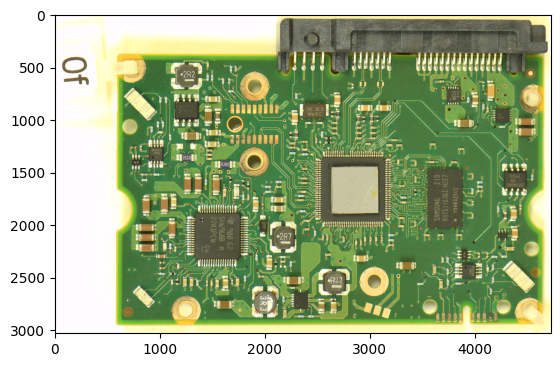

In [21]:
sample_idx = 0
img = Image.open(os.path.join(TEST_PATH, group_merged_df["image"].values[sample_idx]))
plt.imshow(img)

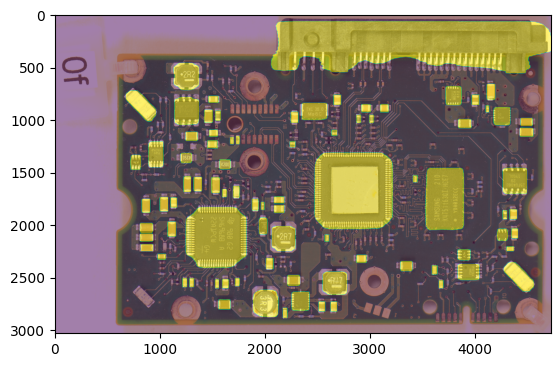

In [22]:
rle_str = group_merged_df["predicted"].values[sample_idx]
height = group_merged_df["height"].values[sample_idx]
width = group_merged_df["width"].values[sample_idx]
sample_rle = rle.rle_decode(rle_str, (height, width), color=1)
plt.imshow(img)
plt.imshow(sample_rle, alpha=0.5)

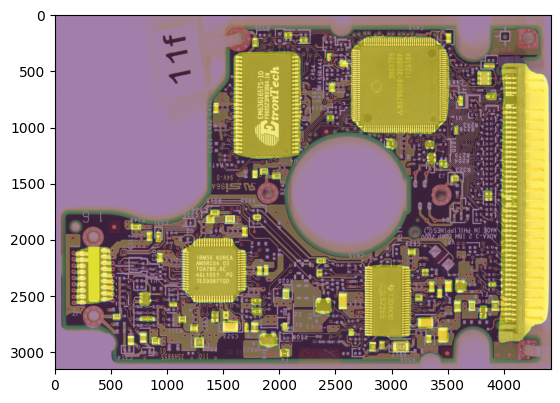

In [57]:
rle_str = group_merged_df["predicted"].values[sample_idx]
height = group_merged_df["height"].values[sample_idx]
width = group_merged_df["width"].values[sample_idx]
sample_rle = rle.rle_decode(rle_str, (height, width), color=1)
plt.imshow(img)
plt.imshow(sample_rle, alpha=0.5)

おおよそ予測ができているようですが、モデルの変更や前処理等でさらにスコアを伸ばせると考えられます。

これにて、チュートリアルコードは終了となります！

# 参考文献
- [1]He, Kaiming, et al. "Mask r-cnn." Proceedings of the IEEE international conference on computer vision. 2017.[https://arxiv.org/abs/1703.06870](https://arxiv.org/abs/1703.06870)
- [2][maskrcnn_resnet50_fpn](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html)